# TREBL Full Analysis Example

This notebook demonstrates a comprehensive TREBL analysis workflow with:
- **Error correction enabled** (improves accuracy by salvaging sequences)
- **Both simple and directional/complex UMI deduplication** (comprehensive PCR artifact removal)

This approach is recommended for final, publication-quality analysis when accuracy is the priority.

**Note:** Error correction and complex UMI deduplication significantly increase processing time. For large datasets, consider submitting as a Savio job (see `examples/savio_jobs/full_analysis_job.sh`).

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from tqdm import tqdm

from trebl_tools import (
    initial_map,
    map_refiner,
    complexity,
    finder,
    preprocess,
    error_correct,
    plotting,
    umi_deduplicate,
    pipelines,
)

['/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python311.zip', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python3.11', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python3.11/lib-dynload', '', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python3.11/site-packages', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/src']


## Initialize Pipeline

Key settings for full analysis:
- `error_correction=True` - Enables UMI-tools based error correction
- `test_n_reads` - Optional: Set to a number for testing with subset of data

In [3]:
# Initialize pipeline with error correction
pipeline = pipelines.TreblPipeline(
    db_path="../db/full_analysis.db",
    design_file_path="../data/design_file.txt",
    error_correction=True,  # Full analysis: enable error correction
    output_path="../output/full_analysis",
    # test_n_reads=100000  # Uncomment to test with first 100k reads
)

## Step 1: TREBL Mapping with Error Correction

Define barcodes and run initial mapping with error correction enabled.

In [4]:
# Define barcodes to search for in reads
AD = finder.Barcode(name="AD", preceder="GGCTAGC", post="TGACTAG", length=120)

AD_BC = finder.Barcode(name="AD_BC", preceder="CGCGCC", post="GGGCCC", length=11)

RT_BC = finder.Barcode(name="RT_BC", preceder="CTCGAG", post="GGCCGC", length=14)

# Combine barcodes
bc_objects = [AD, AD_BC, RT_BC]


# Separate barcode objects
AD_bc_objects = [AD, AD_BC]  # AD and AD_BC barcodes
RT_bc_objects = [RT_BC]  # Reporter barcodes

In [5]:
# Specify sequencing file(s)
step1_seq_file = "../data/step1_ChopTFs_sample.fastq"
# Can be a single file (string) or multiple files (list of strings)
# Supported formats: .fastq or .fastq.gz

✓ Initial map already exists: step1_AD_AD_BC_RT_BC_initial — skipping
Base prefix (stable across descriptors): step1_AD_AD_BC_RT_BC_
Full prefix for this instance: step1_AD_AD_BC_RT_BC_

Using the following step order:
1. initial
2. grouped

Grouping step1_AD_AD_BC_RT_BC_initial...


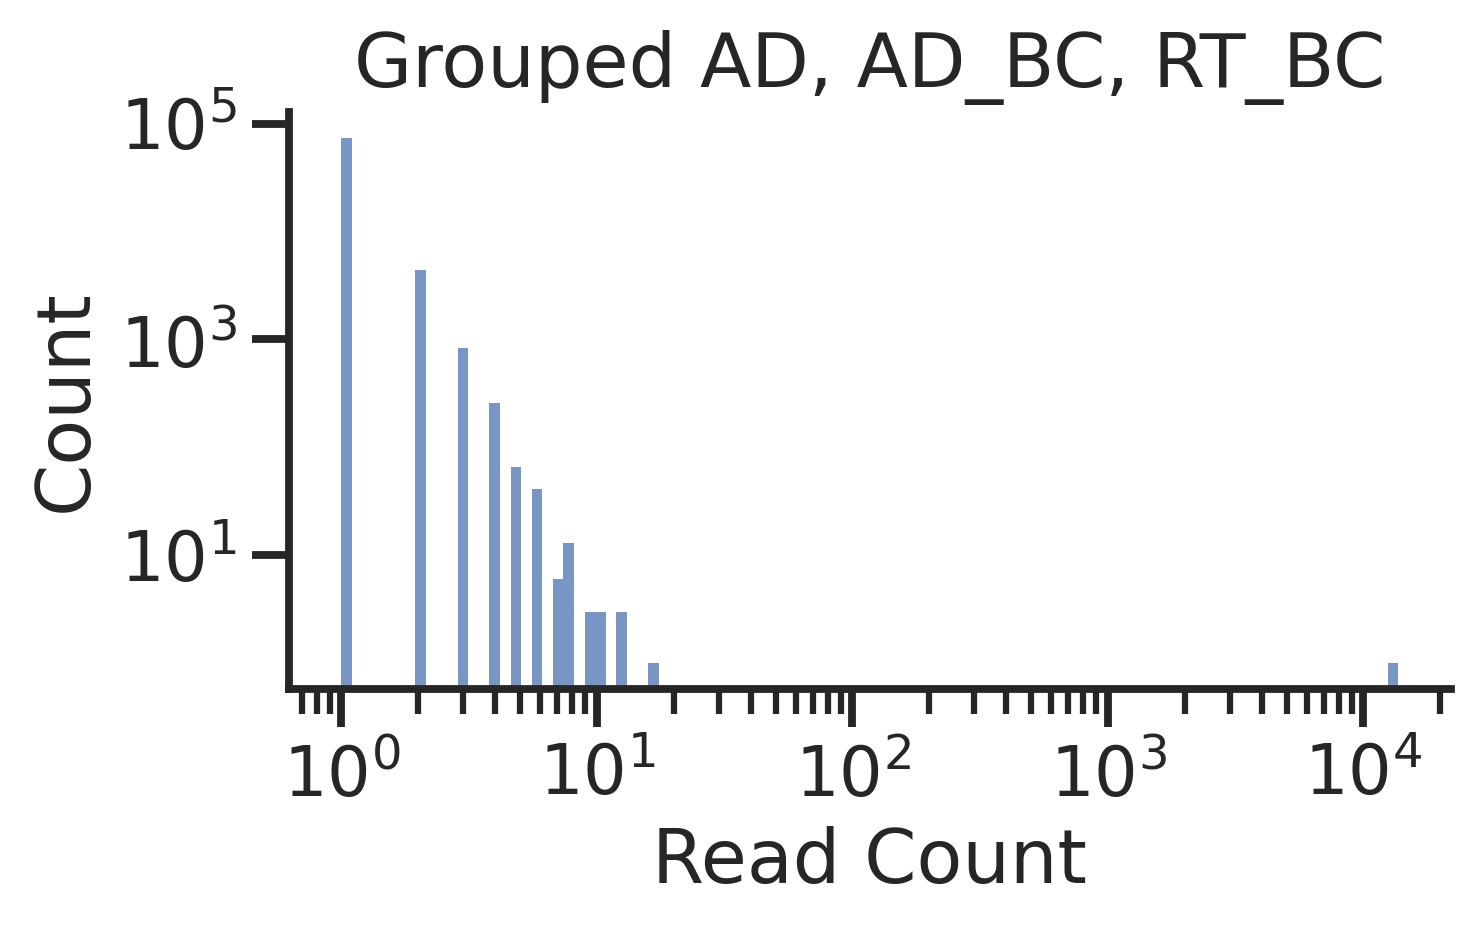

Done in 2.53 seconds.

Done.
Saved loss summary table as 'step1_AD_AD_BC_RT_BC_loss_summary'
Done in 0.23 seconds.



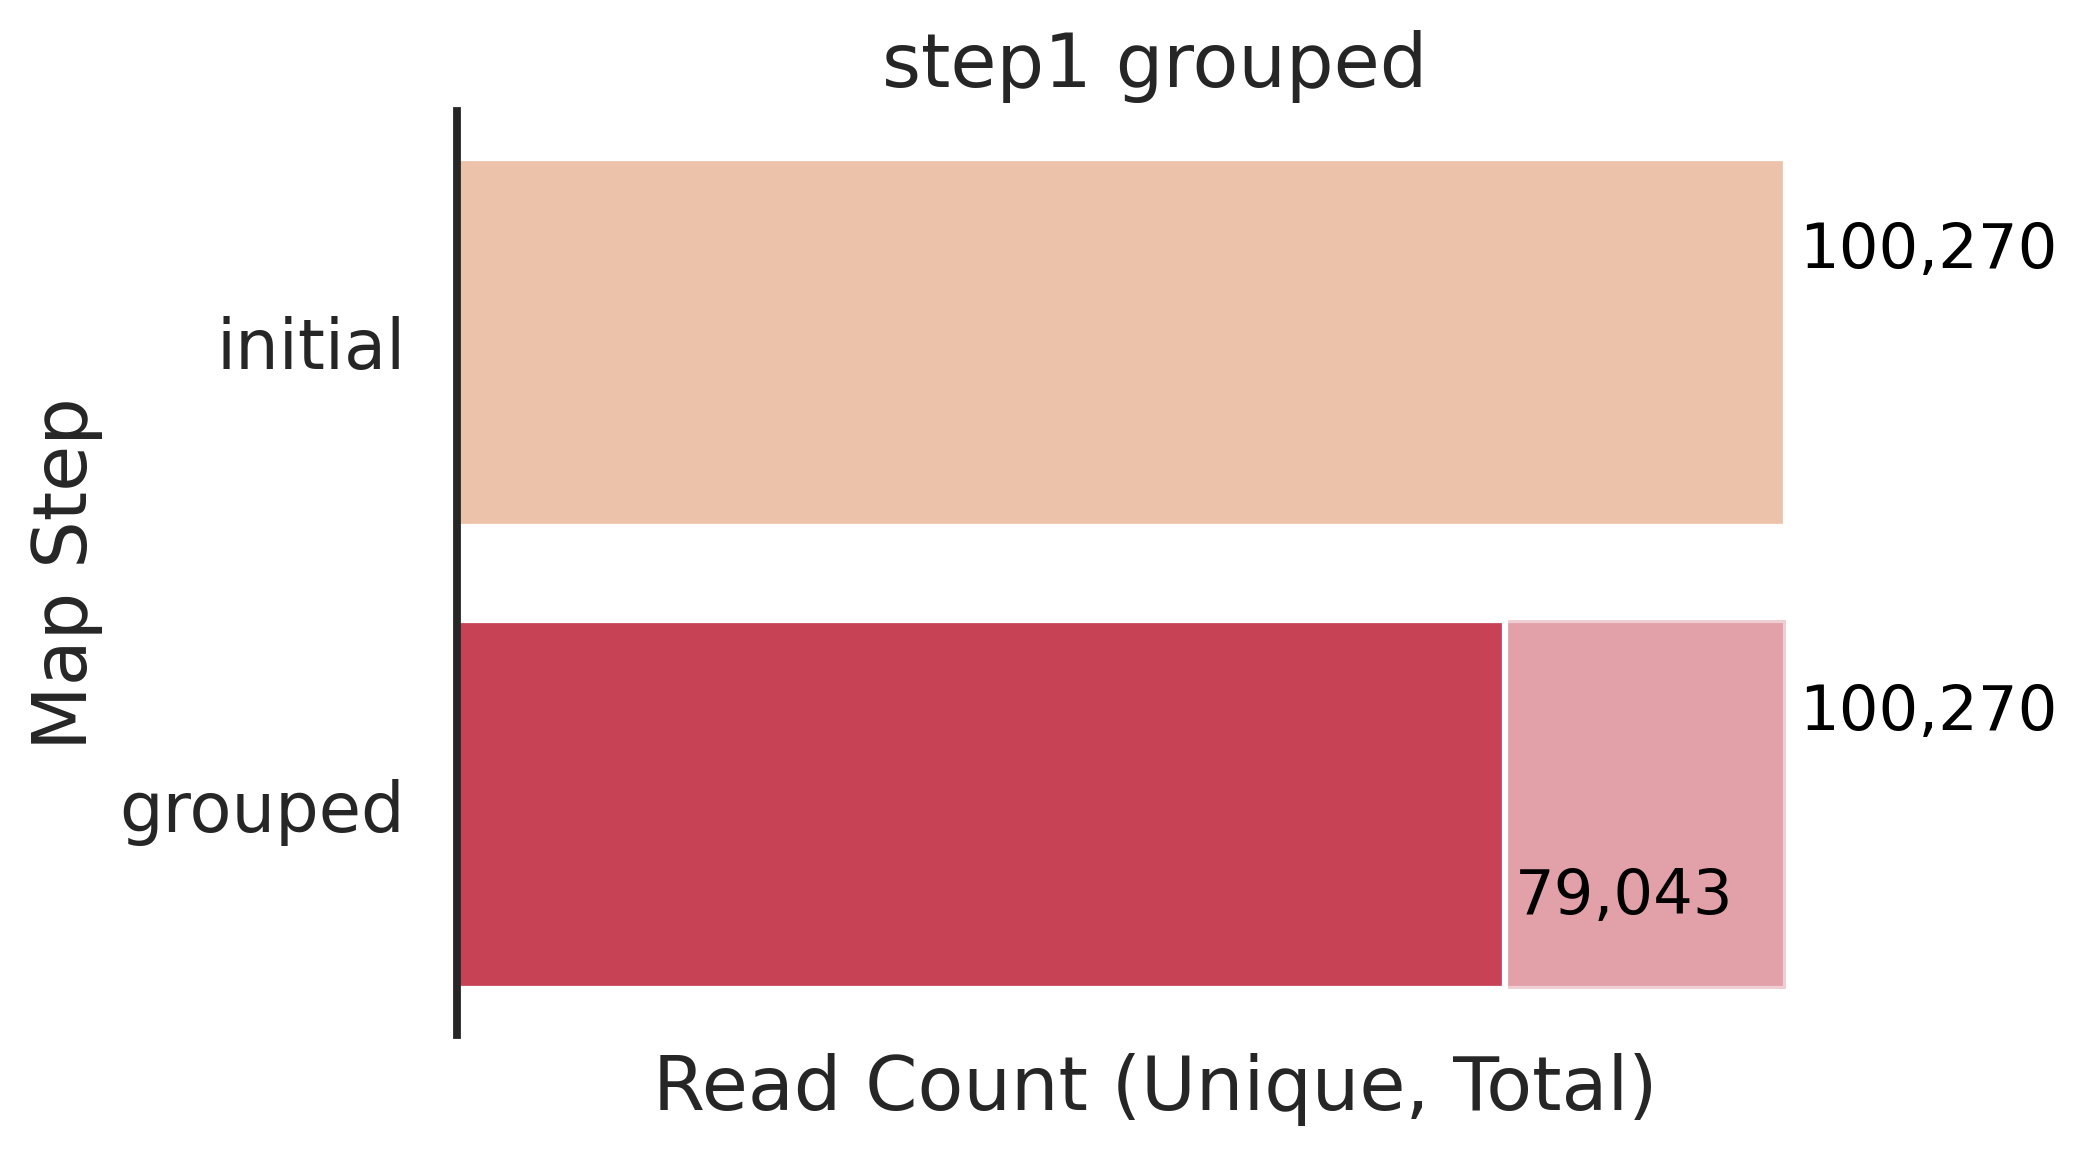

In [6]:
# Plot reads distribution
# NOTE: For large files (>10M reads), consider submitting this as a Savio job
# See examples/savio_jobs/full_analysis_job.sh for job submission example

pipeline.step1_reads_distribution(
    seq_file=step1_seq_file, bc_objects=bc_objects, reverse_complement=True
)
# Produces histogram of reads per barcode
# Helps pick appropriate reads_threshold for filtering

✓ Initial map already exists: step1_AD_AD_BC_RT_BC_initial — skipping
Base prefix (stable across descriptors): step1_AD_AD_BC_RT_BC_
Full prefix for this instance: step1_AD_AD_BC_RT_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. unique_target
8. designed

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.05 seconds.


Filtering to high-quality reads...
Created table: step1_AD_AD_BC_RT_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.01 seconds.


=== Running error correction step on step1_AD_AD_BC_RT_BC_quality ===

=== Applying whitelist for step1 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step1_AD_AD_BC_RT_BC_filtered_barcodes_extracted.fastq
Wrote 4168 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step1_AD_AD_BC_RT_BC_fi

/global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)


Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step1_AD_AD_BC_RT_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step1_AD_AD_BC_RT_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step1_AD_AD_BC_RT_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 71
Merging with design file...
Done in 0.08 seconds.

Whitelist application complete for step1 at step1_AD_AD_BC_RT_BC_error_corrected
Done in 8.72 seconds.

Grouping step1_AD_AD_BC_RT_BC_error_corrected...


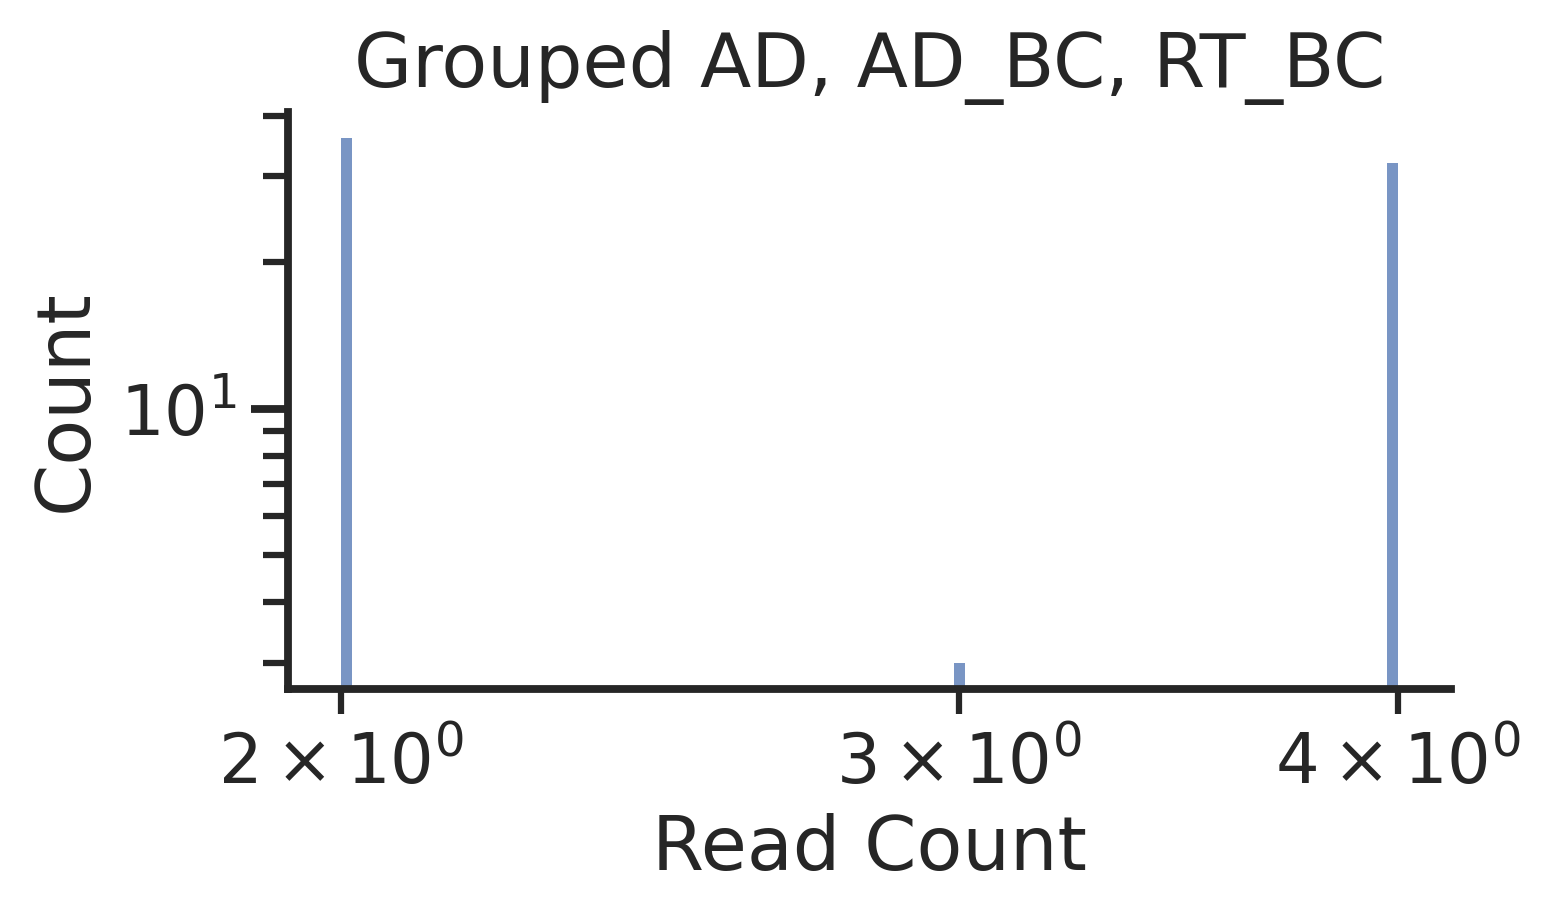

Done in 0.75 seconds.

Thresholding...
Using reads threshold of 1.


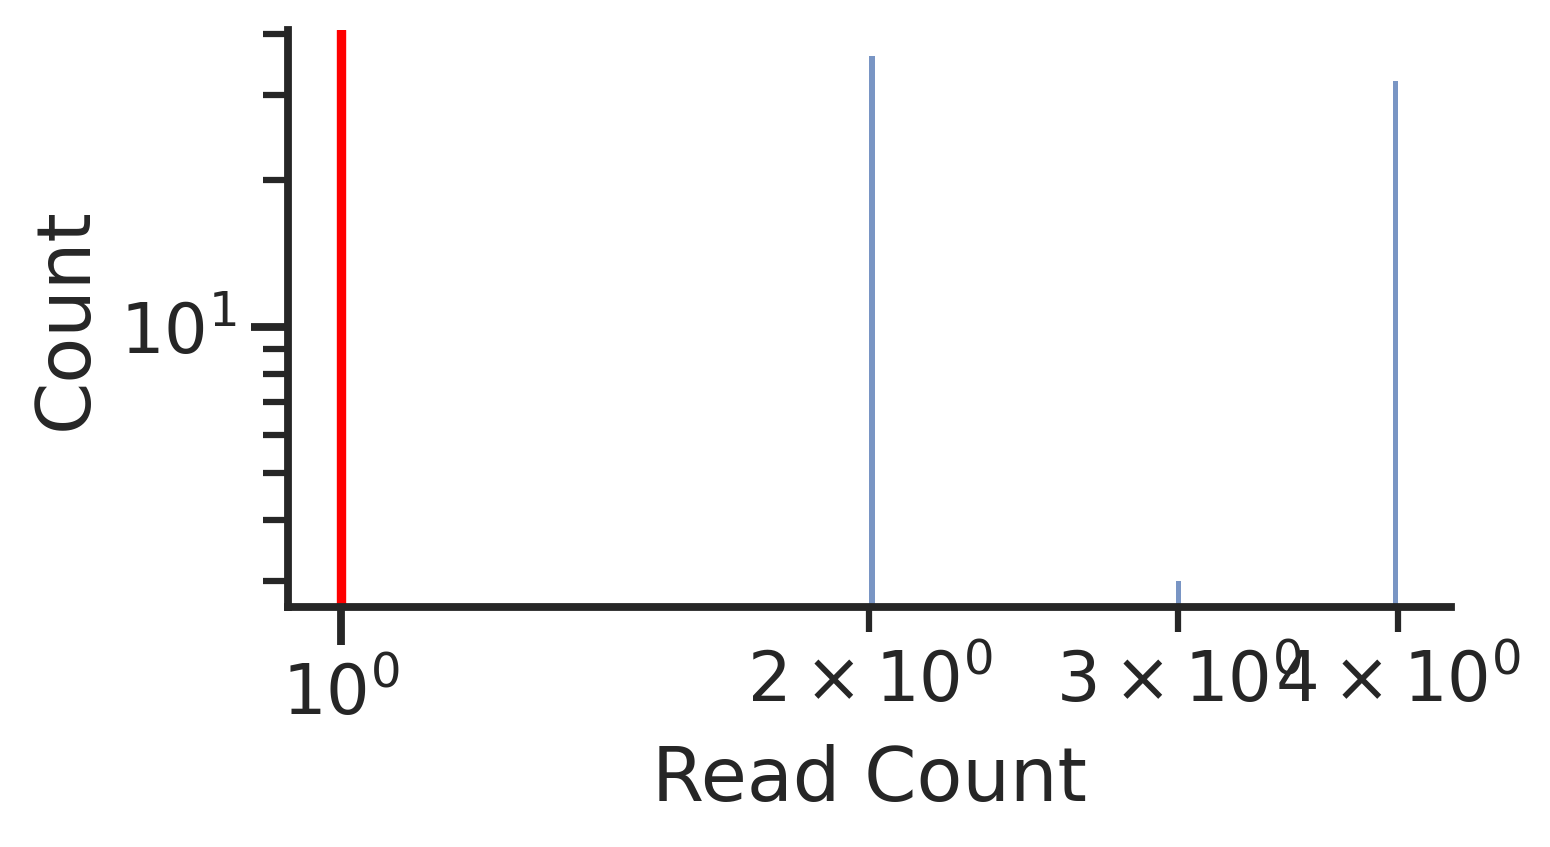

Done in 0.69 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: RT_BC → AD
Created filtered table: step1_AD_AD_BC_RT_BC_unique_target
Done in 0.04 seconds.


Filtering to designed sequences...
Created table: step1_AD_AD_BC_RT_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'step1_AD_AD_BC_RT_BC_loss_summary'
Done in 0.07 seconds.



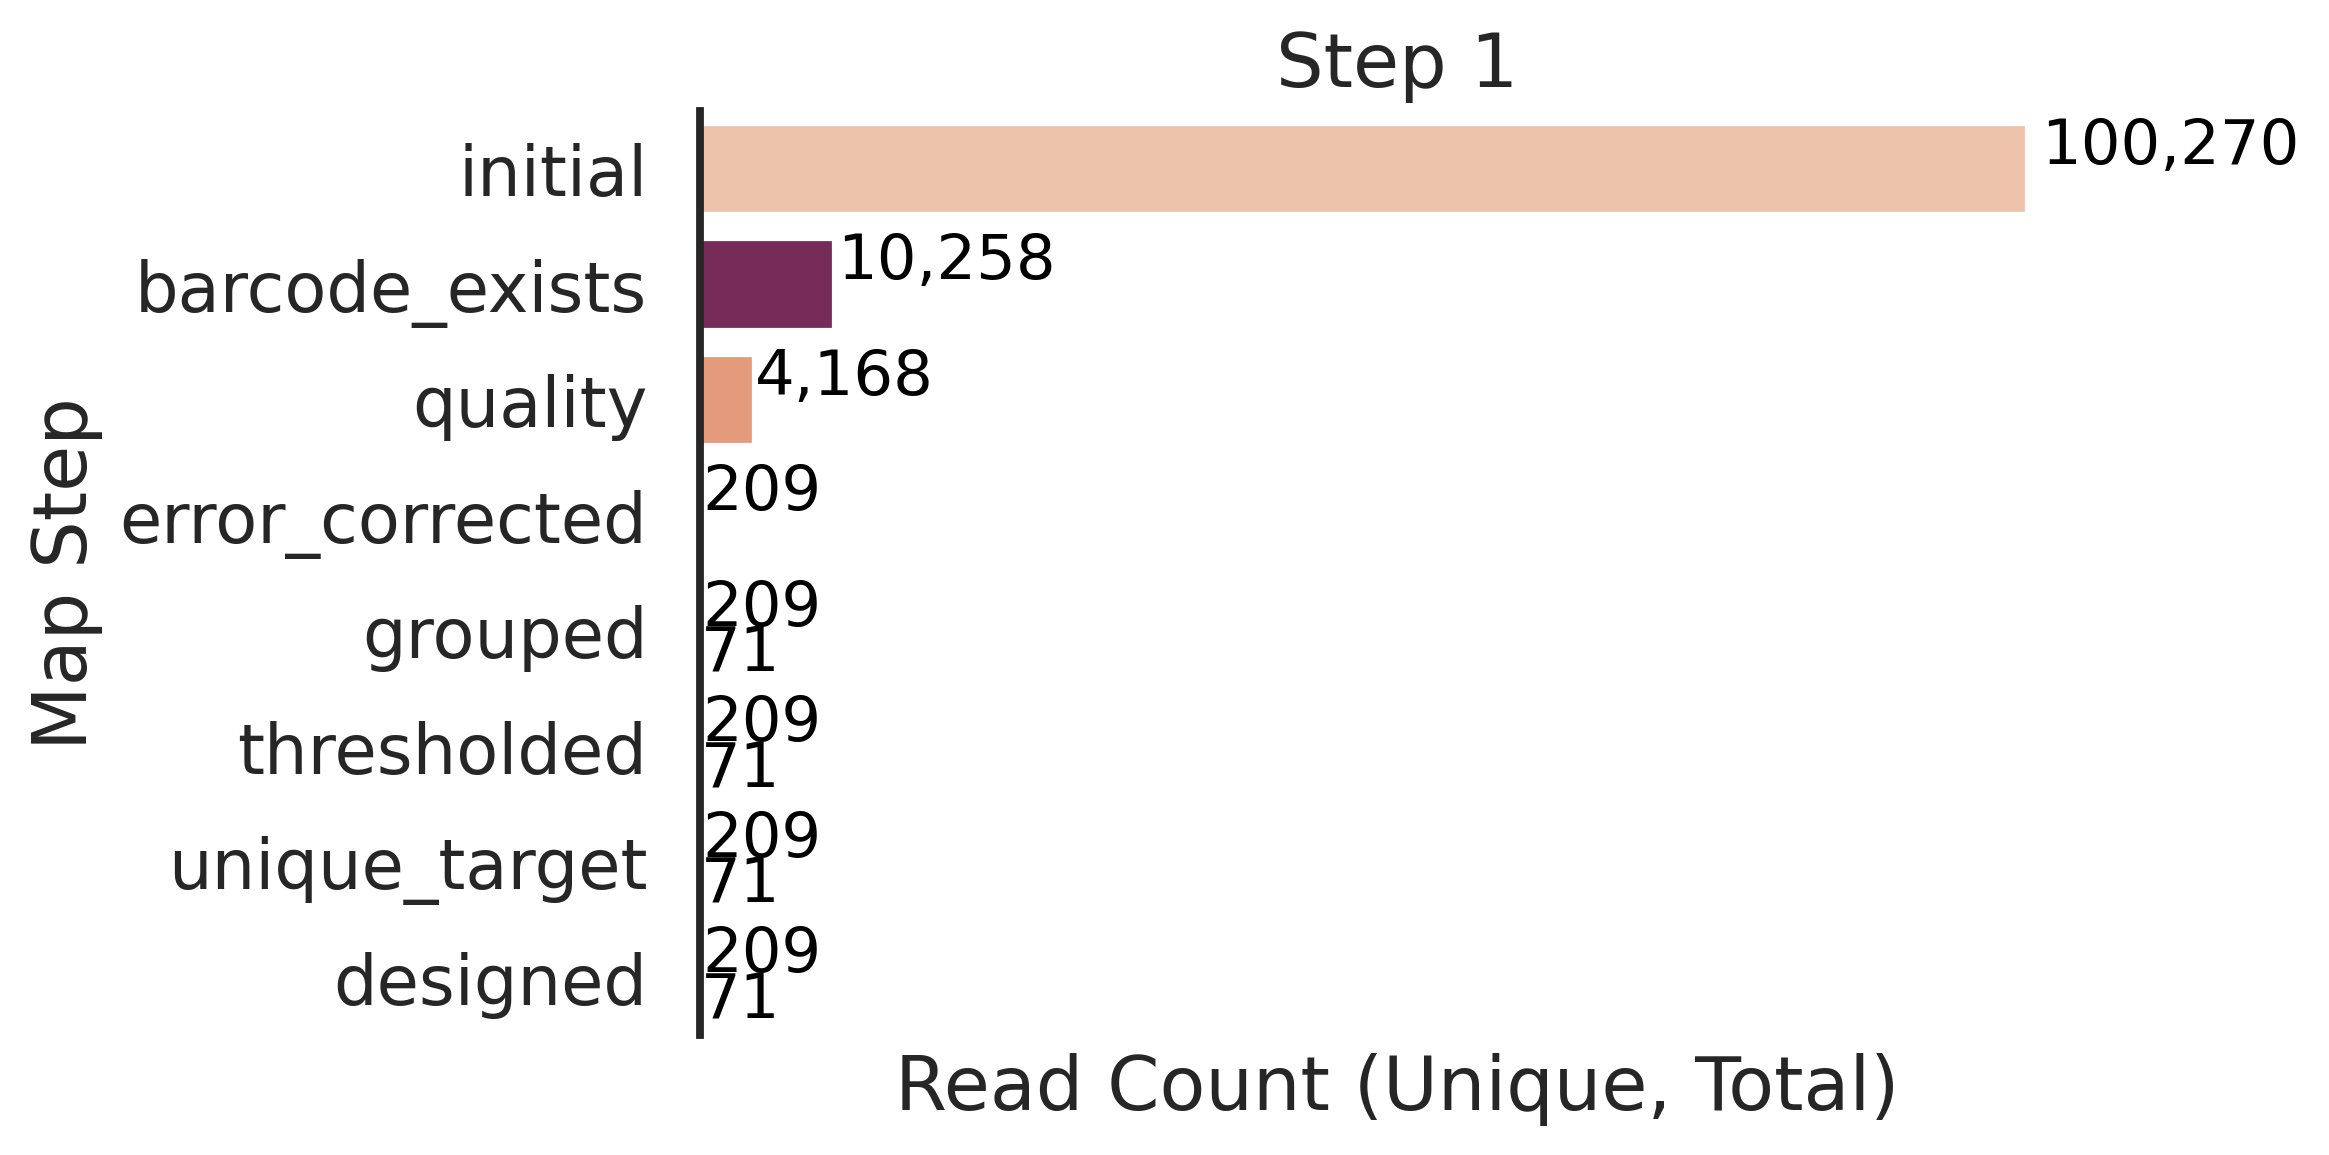

In [7]:
# Run Step 1 mapping with error correction
# Error correction happens automatically based on pipeline initialization
step1_map = pipeline.run_step_1(
    seq_file=step1_seq_file,
    bc_objects=bc_objects,
    column_pairs=[("RT_BC", "AD")],  # Check for collisions between RT_BC and AD
    reads_threshold=1,  # Minimum reads to keep a barcode
    reverse_complement=False,
)
# Returns DataFrame of Step 1 mapping
# Error correction will salvage sequences similar to high-read sequences
# Saves CSV, loss table visualization, and optional loss table CSV

## Step 2: TREBL Step 2 Mapping

Step 2 processes AD and RT libraries that are now in separate sequencing files.

**Note:** Step 1 must be completed successfully before running Step 2.

In [8]:
# Sequencing files for AD and RT (Step 2)
step2_AD_seq_file = "../data/step2_ChopTFs_AD_sample.fastq"
step2_RT_seq_file = "../data/step2_ChopTFs_RT_sample.fastq"
# Can be single files or lists of files; .fastq or .fastq.gz

✓ Initial map already exists: step2_AD_AD_BC_initial — skipping
Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping step2_AD_AD_BC_initial...


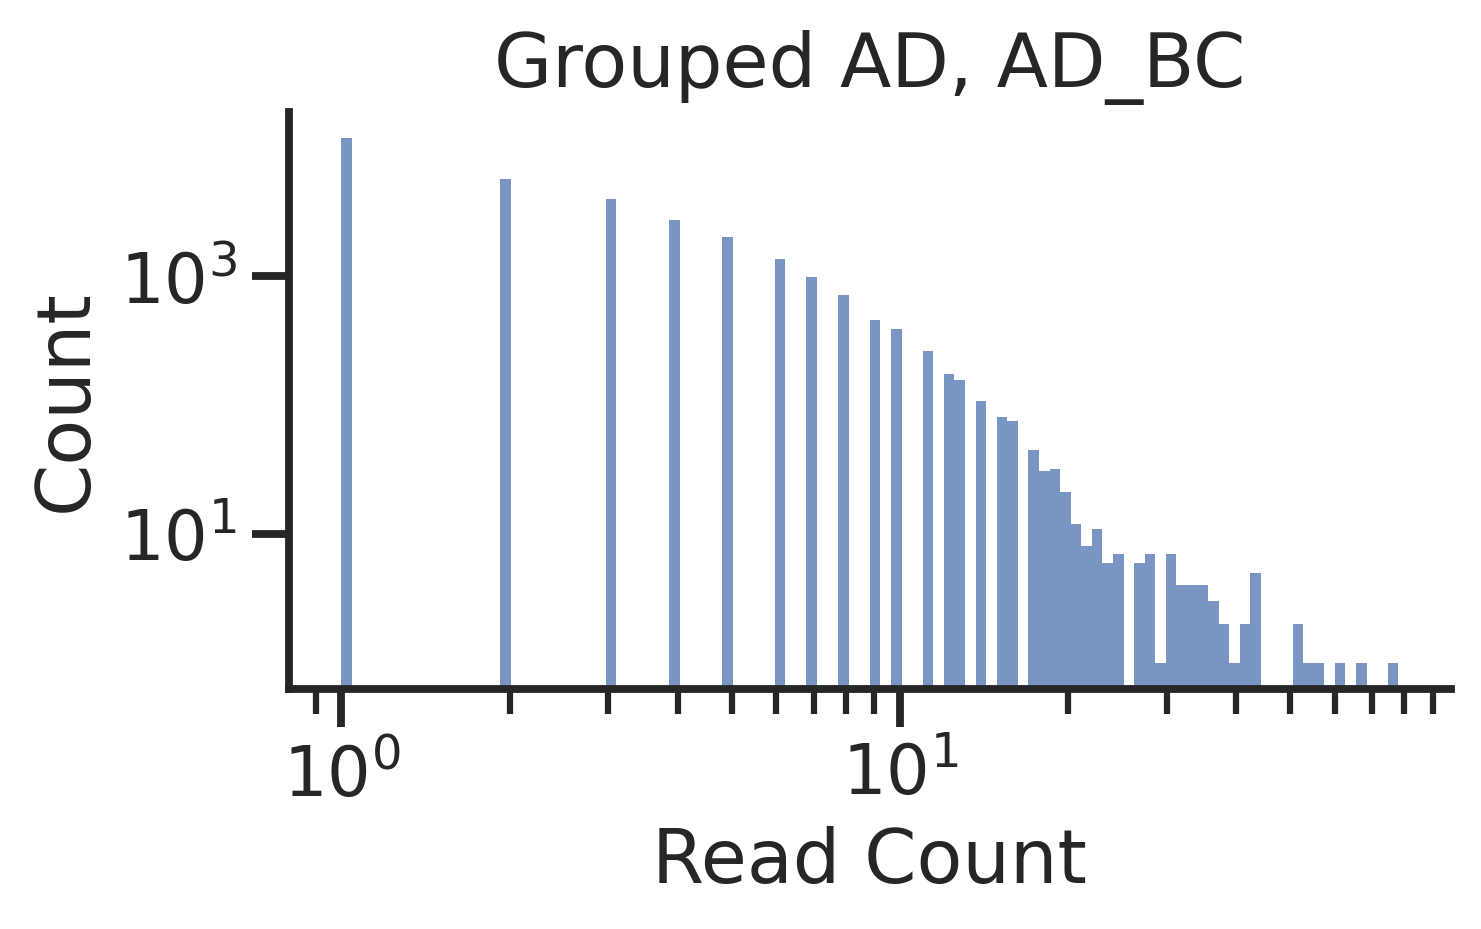

Done in 1.15 seconds.

Done.
Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.14 seconds.

✓ Initial map already exists: step2_RT_BC_initial — skipping
Base prefix (stable across descriptors): step2_RT_BC_
Full prefix for this instance: step2_RT_BC_

Using the following step order:
1. initial
2. grouped

Grouping step2_RT_BC_initial...


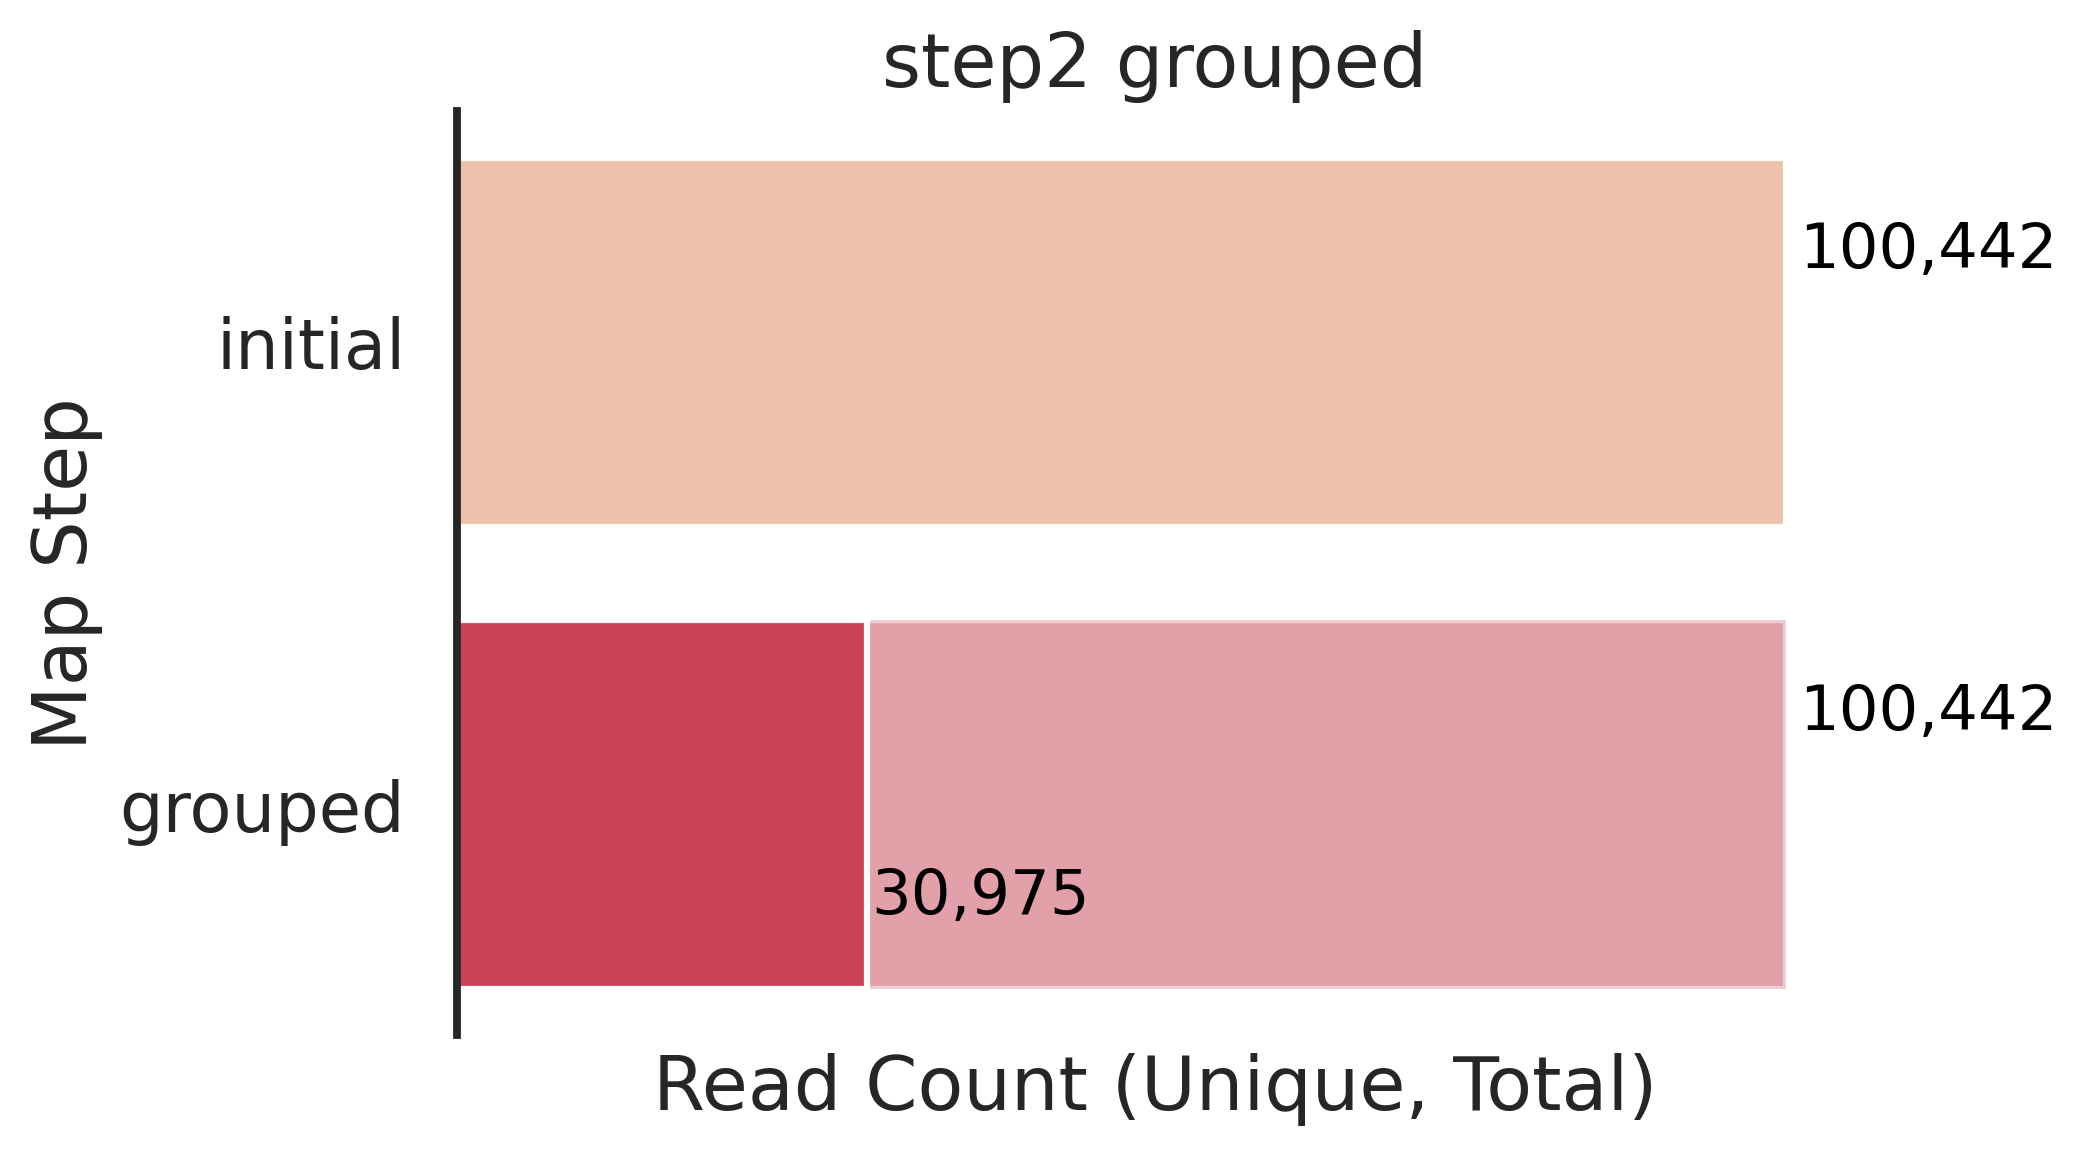

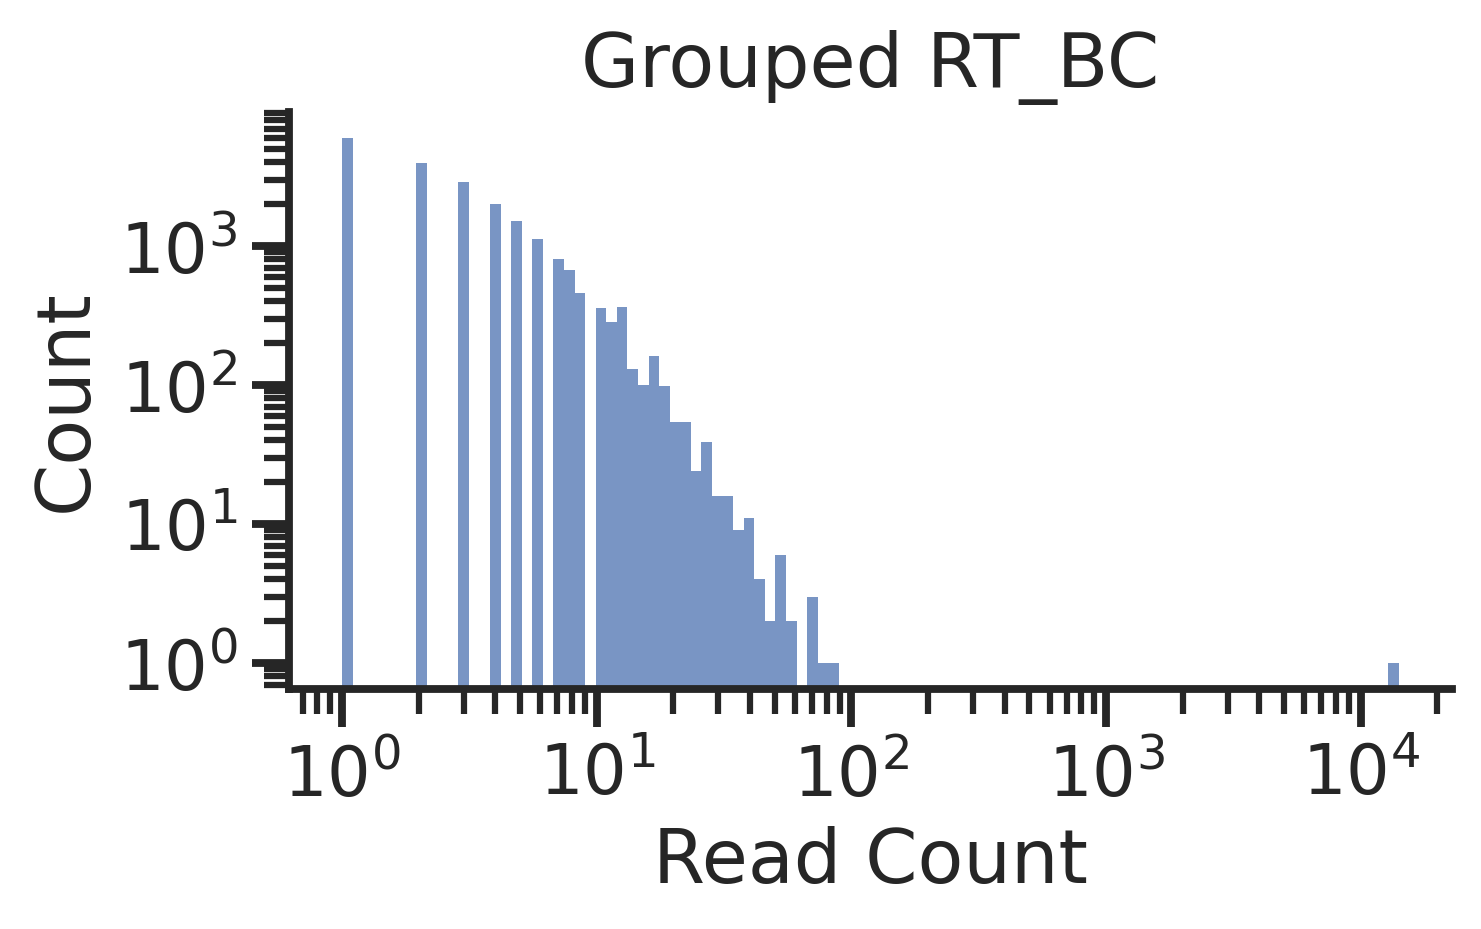

Done in 1.33 seconds.

Done.
Saved loss summary table as 'step2_RT_BC_loss_summary'
Done in 0.02 seconds.



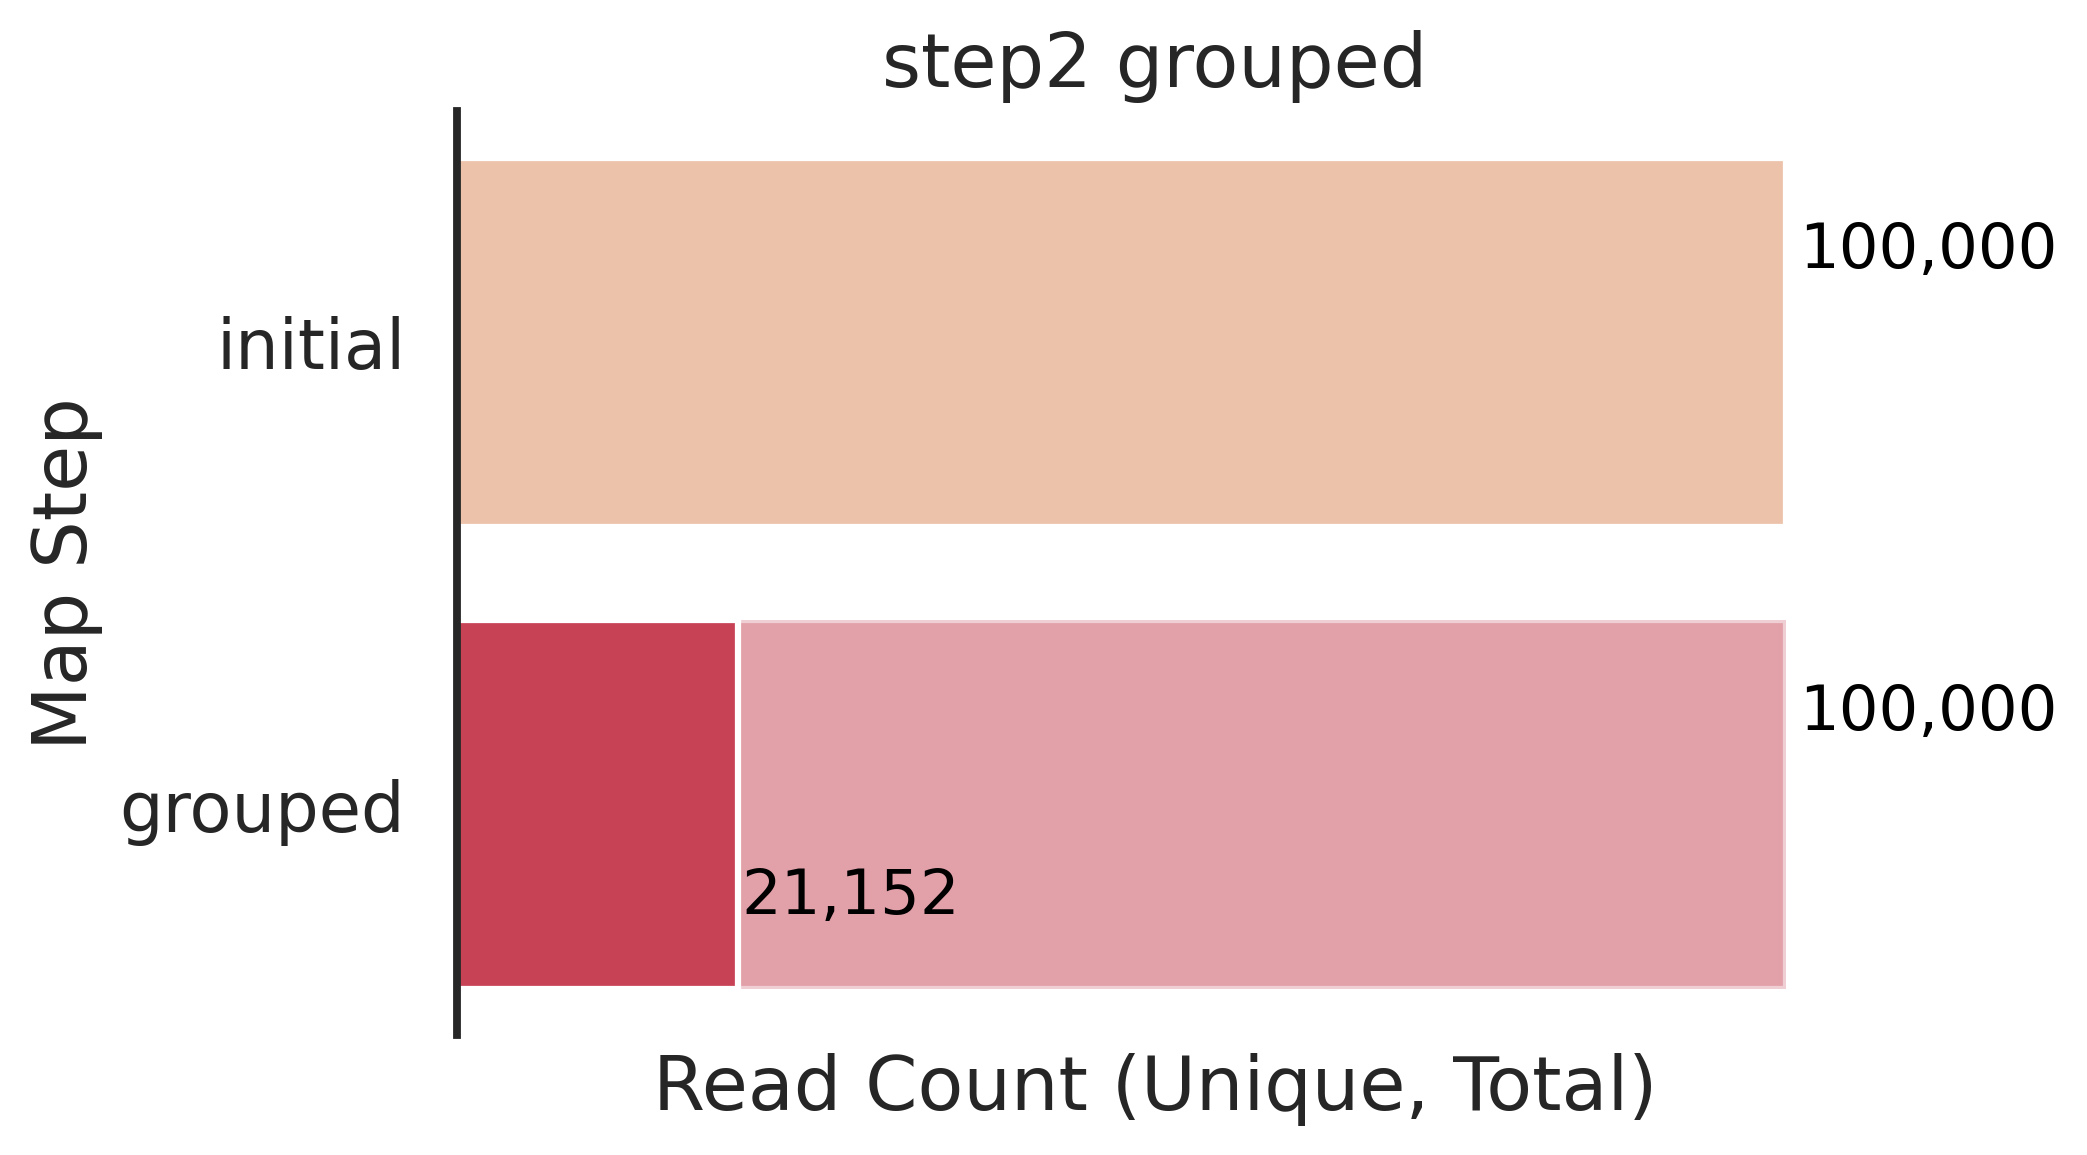

In [9]:
# Plot Step 2 reads distribution
# NOTE: For large files (>10M reads), consider submitting this as a Savio job

pipeline.step2_reads_distribution(
    AD_seq_file=step2_AD_seq_file,
    AD_bc_objects=AD_bc_objects,
    RT_seq_file=step2_RT_seq_file,
    RT_bc_objects=RT_bc_objects,
    reverse_complement=True,
)
# Produces histograms for AD and RT reads
# Helps pick reads_threshold_AD and reads_threshold_RT

✓ Initial map already exists: step2_AD_AD_BC_initial — skipping
✓ Initial map already exists: step2_RT_BC_initial — skipping
Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. designed

Base prefix (stable across descriptors): step2_RT_BC_
Full prefix for this instance: step2_RT_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. designed

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.12 seconds.


Filtering to high-quality reads...
Created table: step2_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.46 seconds.


=== Running error correction step on step2_AD_AD_BC_quality ===

=== Applying whitelist for step2 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools

/global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)


Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_AD_AD_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_AD_AD_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_AD_AD_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 11999
Merging with design file...
Done in 0.17 seconds.

Whitelist application complete for step2 at step2_AD_AD_BC_error_corrected
Done in 16.20 seconds.

Grouping step2_AD_AD_BC_error_corrected...


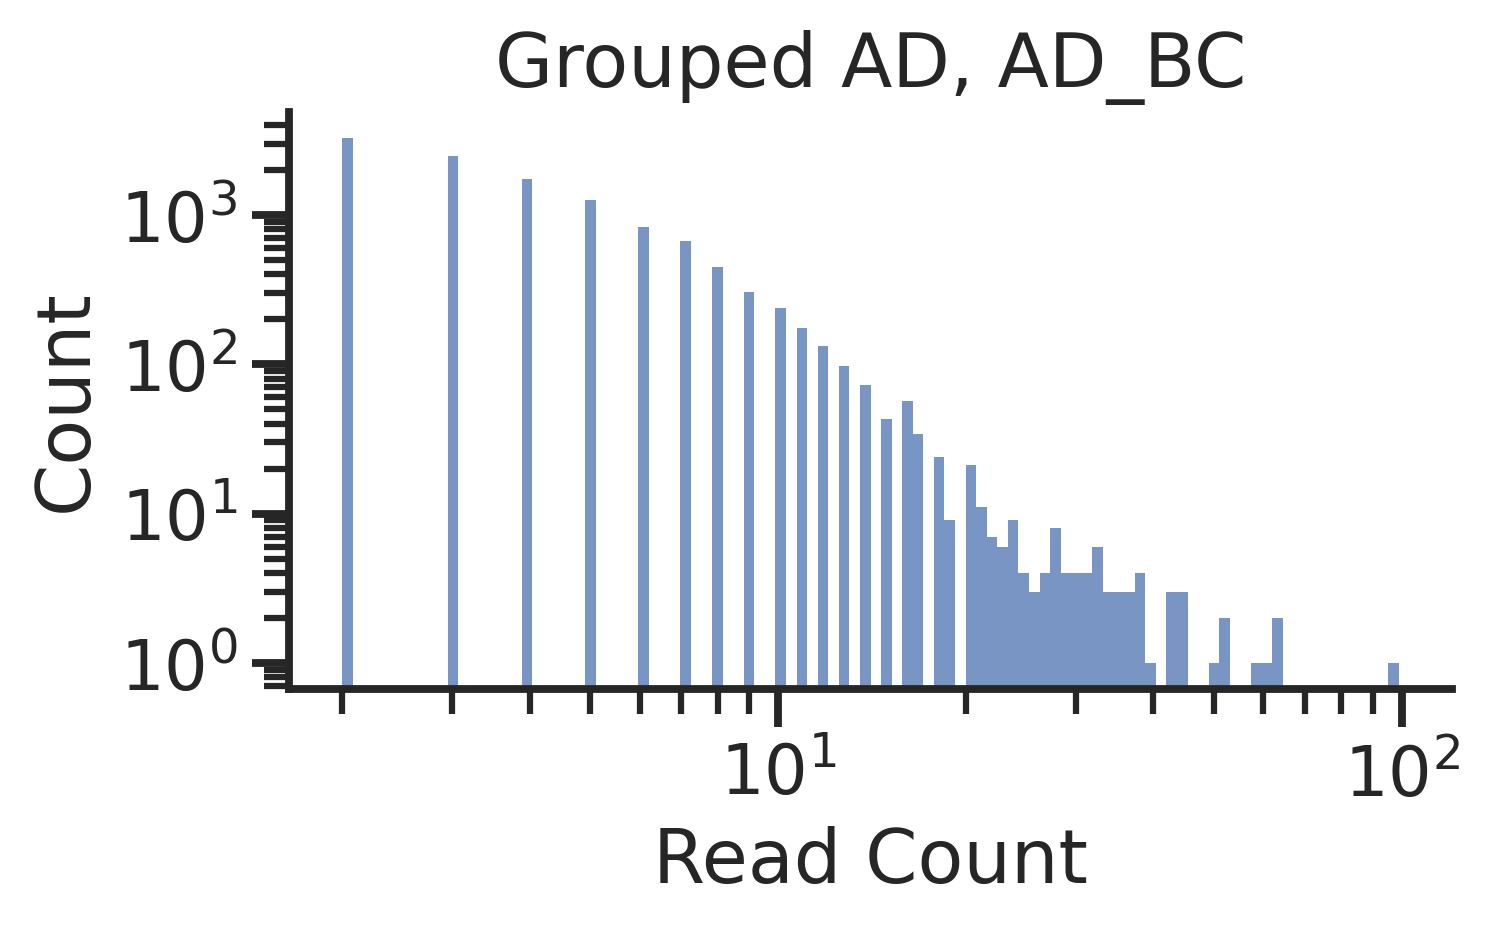

Done in 1.02 seconds.

Thresholding...
Using reads threshold of 1.


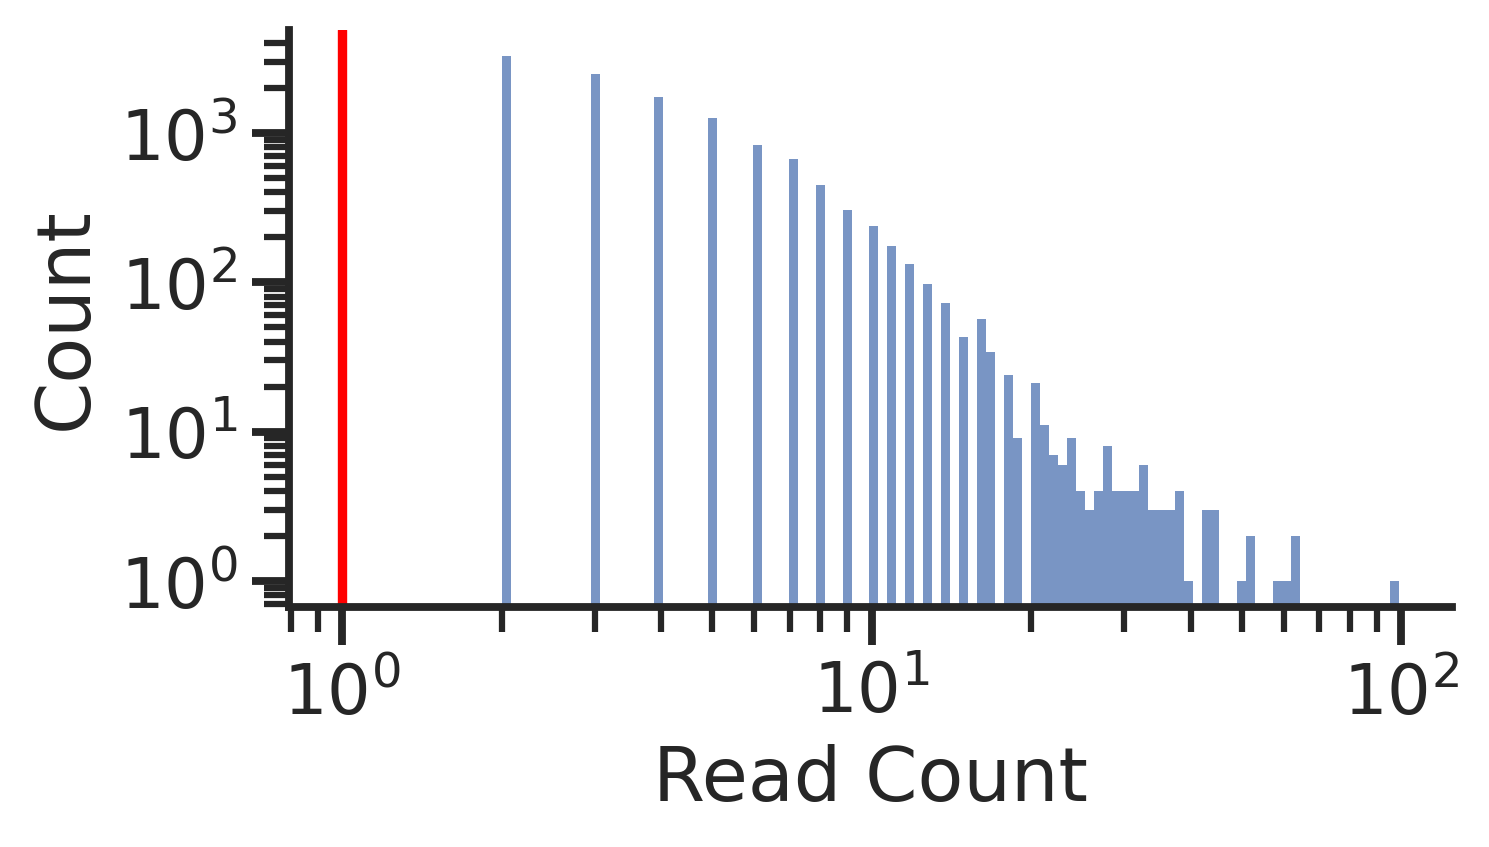

Done in 1.05 seconds.


Filtering to designed sequences...
Created table: step2_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.02 seconds.

Done.
Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.11 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.05 seconds.


Filtering to high-quality reads...
Created table: step2_RT_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.03 seconds.


=== Running error correction step on step2_RT_BC_quality ===

=== Applying whitelist for step2 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_RT_BC_filtered_barcodes_extracted.fastq
Wrote 85069 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_RT_BC_filtered_barcodes_extracted.fastq
Done in 0.06 seconds.

Inferring expected barcode count from grouped reads...
Using reads threshold of

/global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)


Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_RT_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_RT_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/figures/step2_RT_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 15011
Done in 0.04 seconds.

Whitelist application complete for step2 at step2_RT_BC_error_corrected
Done in 16.71 seconds.

Grouping step2_RT_BC_error_corrected...


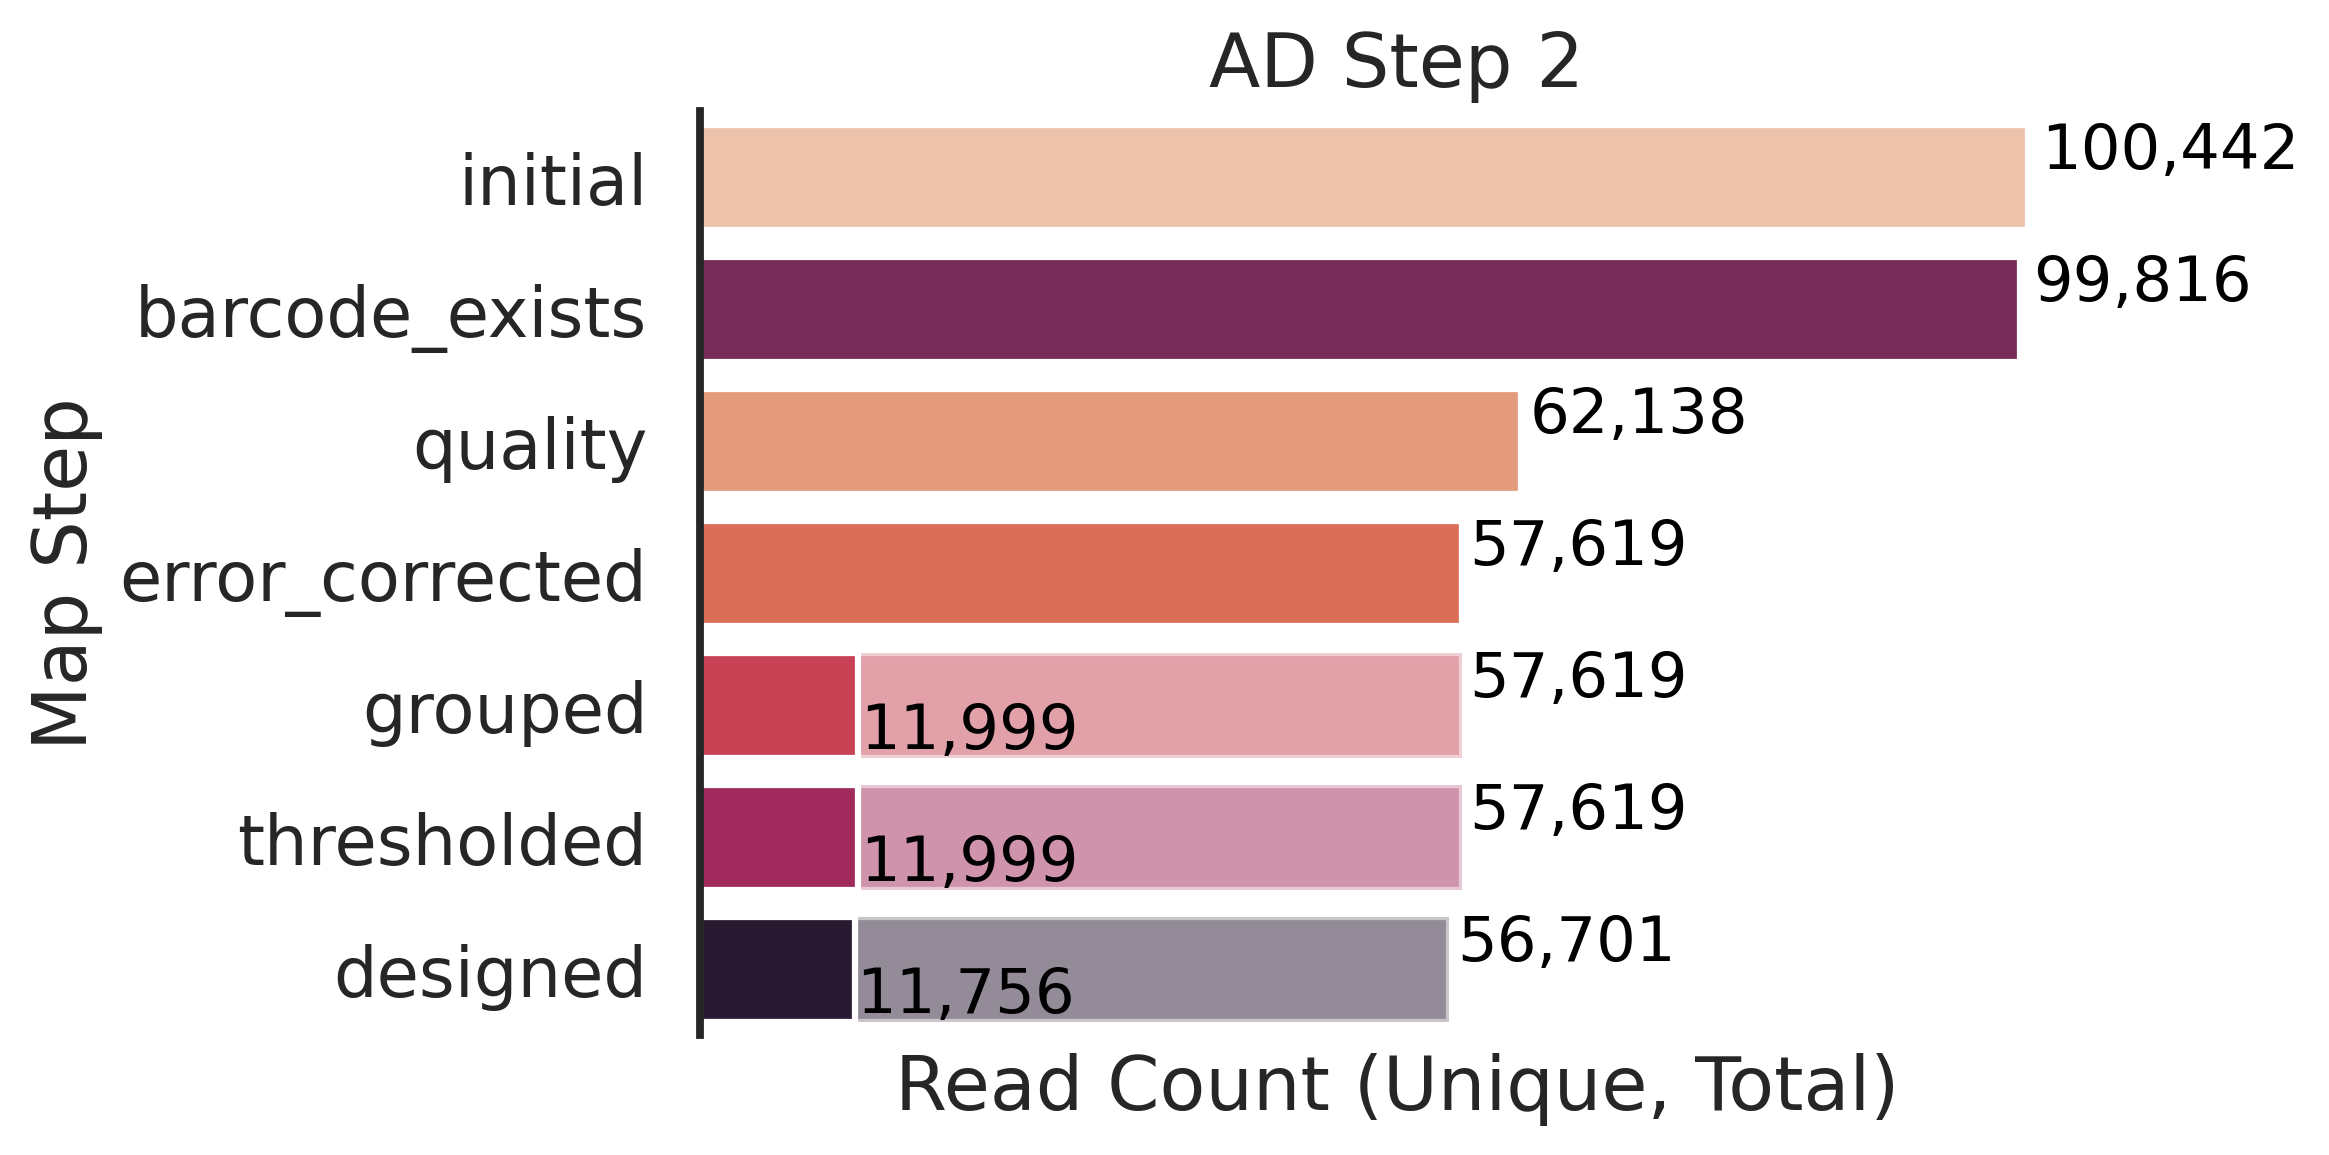

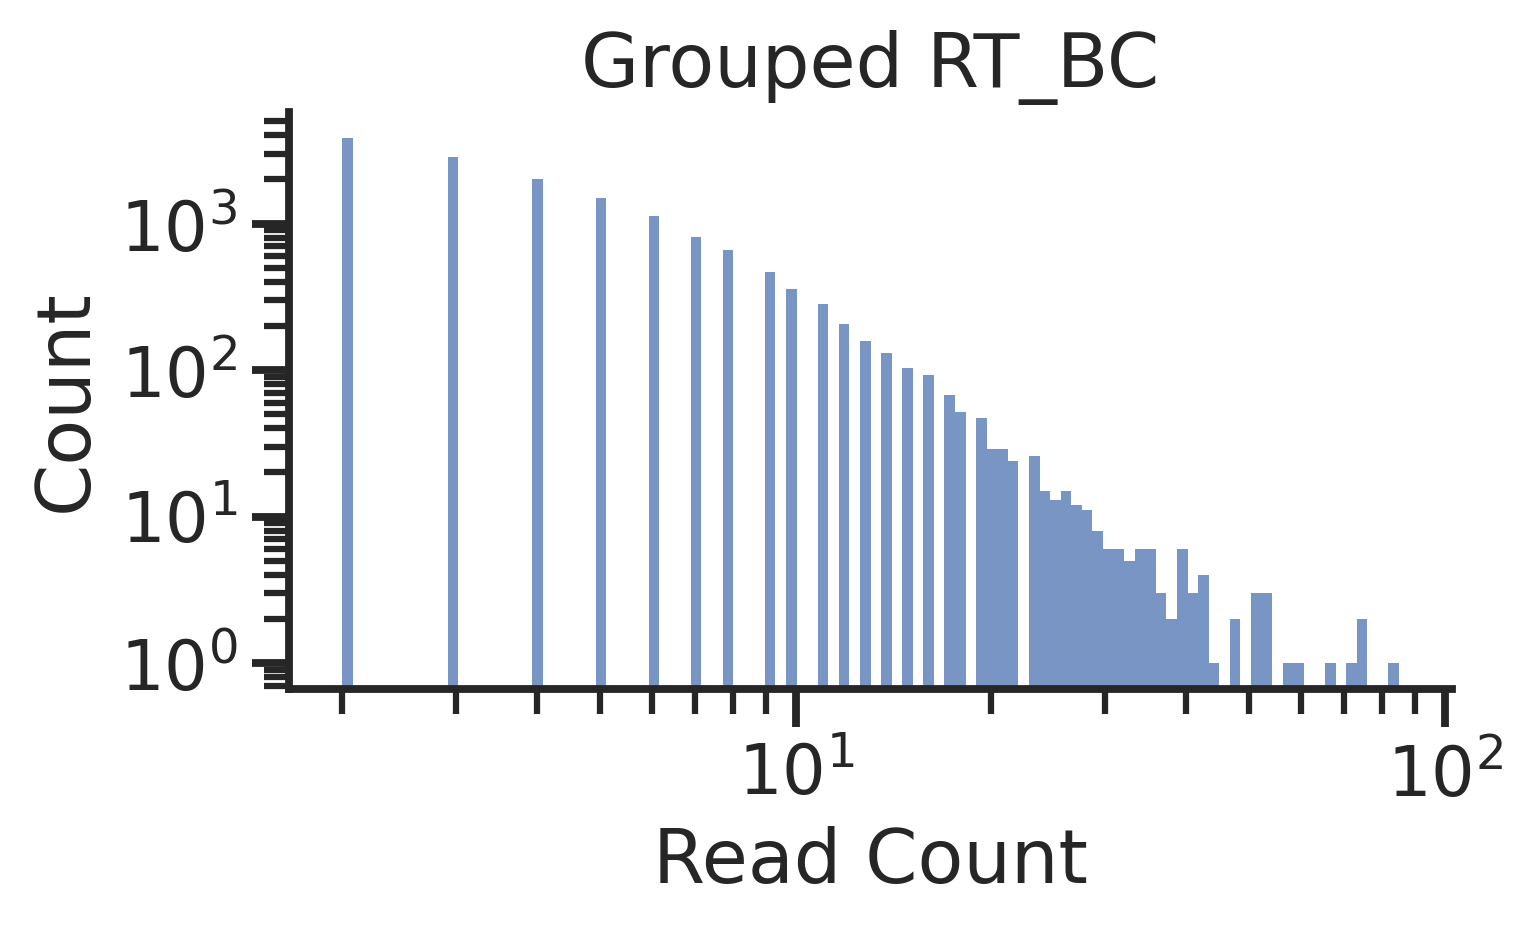

Done in 1.21 seconds.

Thresholding...
Using reads threshold of 1.


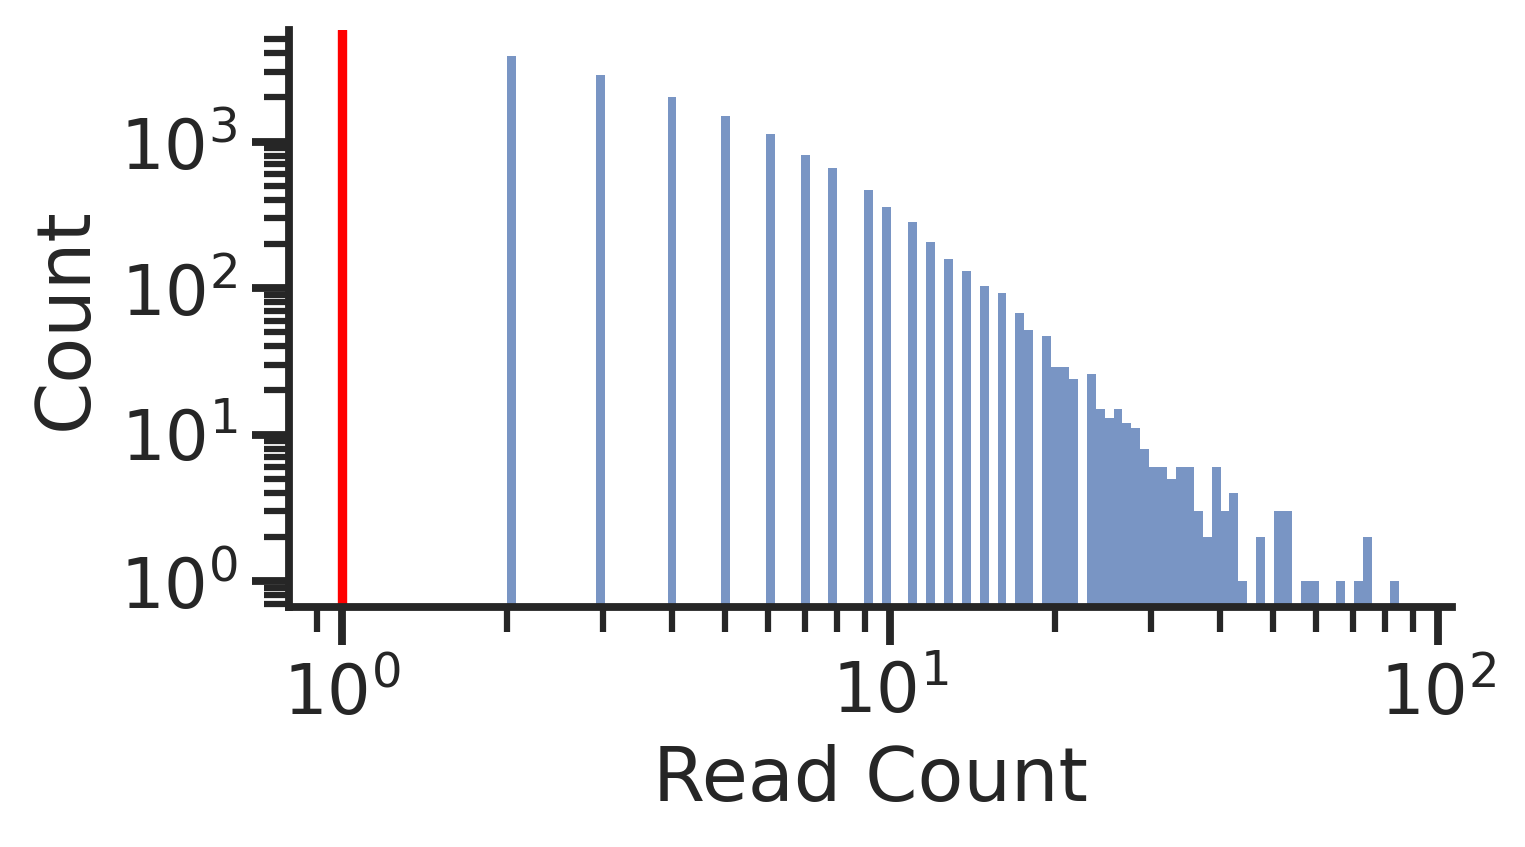

Done in 0.89 seconds.


Filtering to designed sequences...
Created table: step2_RT_BC_designed — kept only Designed == 1.
Done in 0.01 seconds.

Done.
Saved loss summary table as 'step2_RT_BC_loss_summary'
Done in 0.03 seconds.



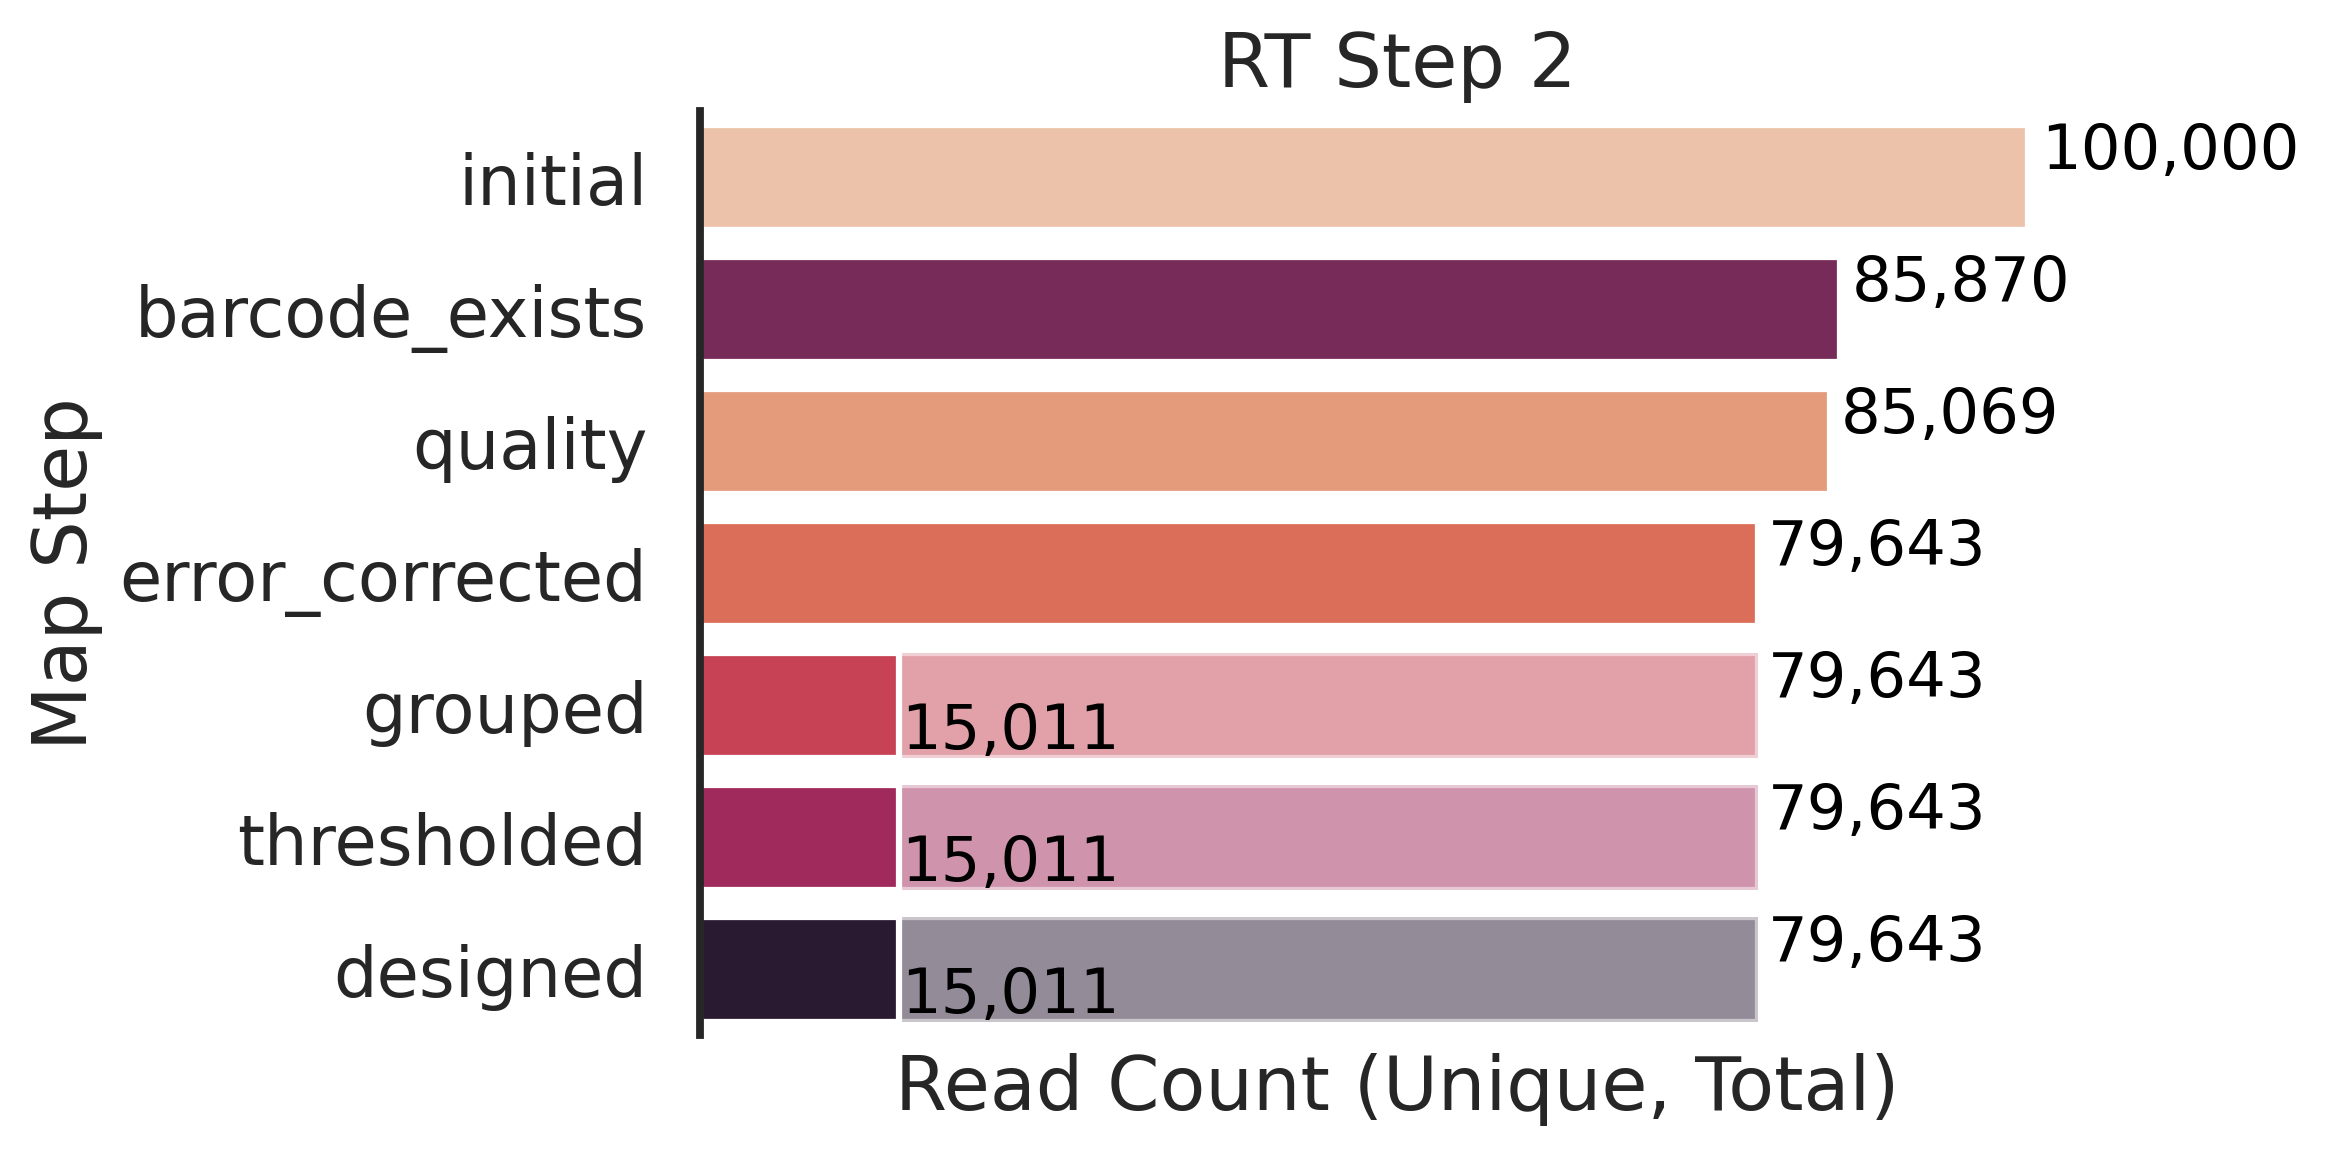

In [10]:
# Run Step 2 mapping with error correction
# Error correction happens automatically based on pipeline initialization
step2 = pipeline.run_step_2(
    AD_seq_file=step2_AD_seq_file,
    AD_bc_objects=AD_bc_objects,
    RT_seq_file=step2_RT_seq_file,
    RT_bc_objects=RT_bc_objects,
    reverse_complement=True,
    reads_threshold_AD=1,
    reads_threshold_RT=1,
    step1_map_csv_path="../output/full_analysis/step1.csv",  # Update with your step1 CSV path
)

# Extract outputs
AD_step2 = step2["AD_step2"]
RT_step2 = step2["RT_step2"]
step1_overlap = step2["step1_overlap"]

# The overlap shows how well Step 2 data aligns with Step 1 mapping

In [11]:
step1_overlap

,BC_type,map_unique,step2,seen_in_both,percent_of_map_seen
0,"AD,AD_BC",71,11756,8,11.268
1,RT_BC,71,15011,3,4.225


## TREBL Experiment with Both UMI Deduplication Methods

Process the full TREBL experiment using both simple and directional/complex UMI deduplication.

**UMI Deduplication Methods:**
- **Simple:** Counts unique UMI sequences (faster, good baseline)
- **Directional/Complex:** Uses UMI-tools directional algorithm to account for PCR and sequencing errors in UMIs (more accurate)

In [12]:
# Define UMI objects
AD_UMI = finder.Barcode(name="UMI", preceder="TGATTT", post="", length=12)

RT_UMI = finder.Barcode(name="UMI", preceder="TGTCAC", post="", length=12)

In [13]:
# Collect sequencing files
trebl_AD_seq_files = [
    "../data/trebl_experiment_ChopTFs_AD_t10_r2.fastq",
    "../data/trebl_experiment_ChopTFs_AD_t60_r2.fastq",
]
trebl_RT_seq_files = [
    "../data/trebl_experiment_ChopTFs_RT_t10_r2.fastq",
    "../data/trebl_experiment_ChopTFs_RT_t60_r2.fastq",
]

HI
✓ Initial map already exists: trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_initial — skipping
Base prefix (stable across descriptors): trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_
Full prefix for this instance: trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. error_corrected


Filtering to high-quality reads...
Created table: trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.05 seconds.


=== Running error correction step on trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_quality ===

=== Applying whitelist for trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_filter

/global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)


Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 26
Done in 0.01 seconds.

Whitelist application complete for trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2 at trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD

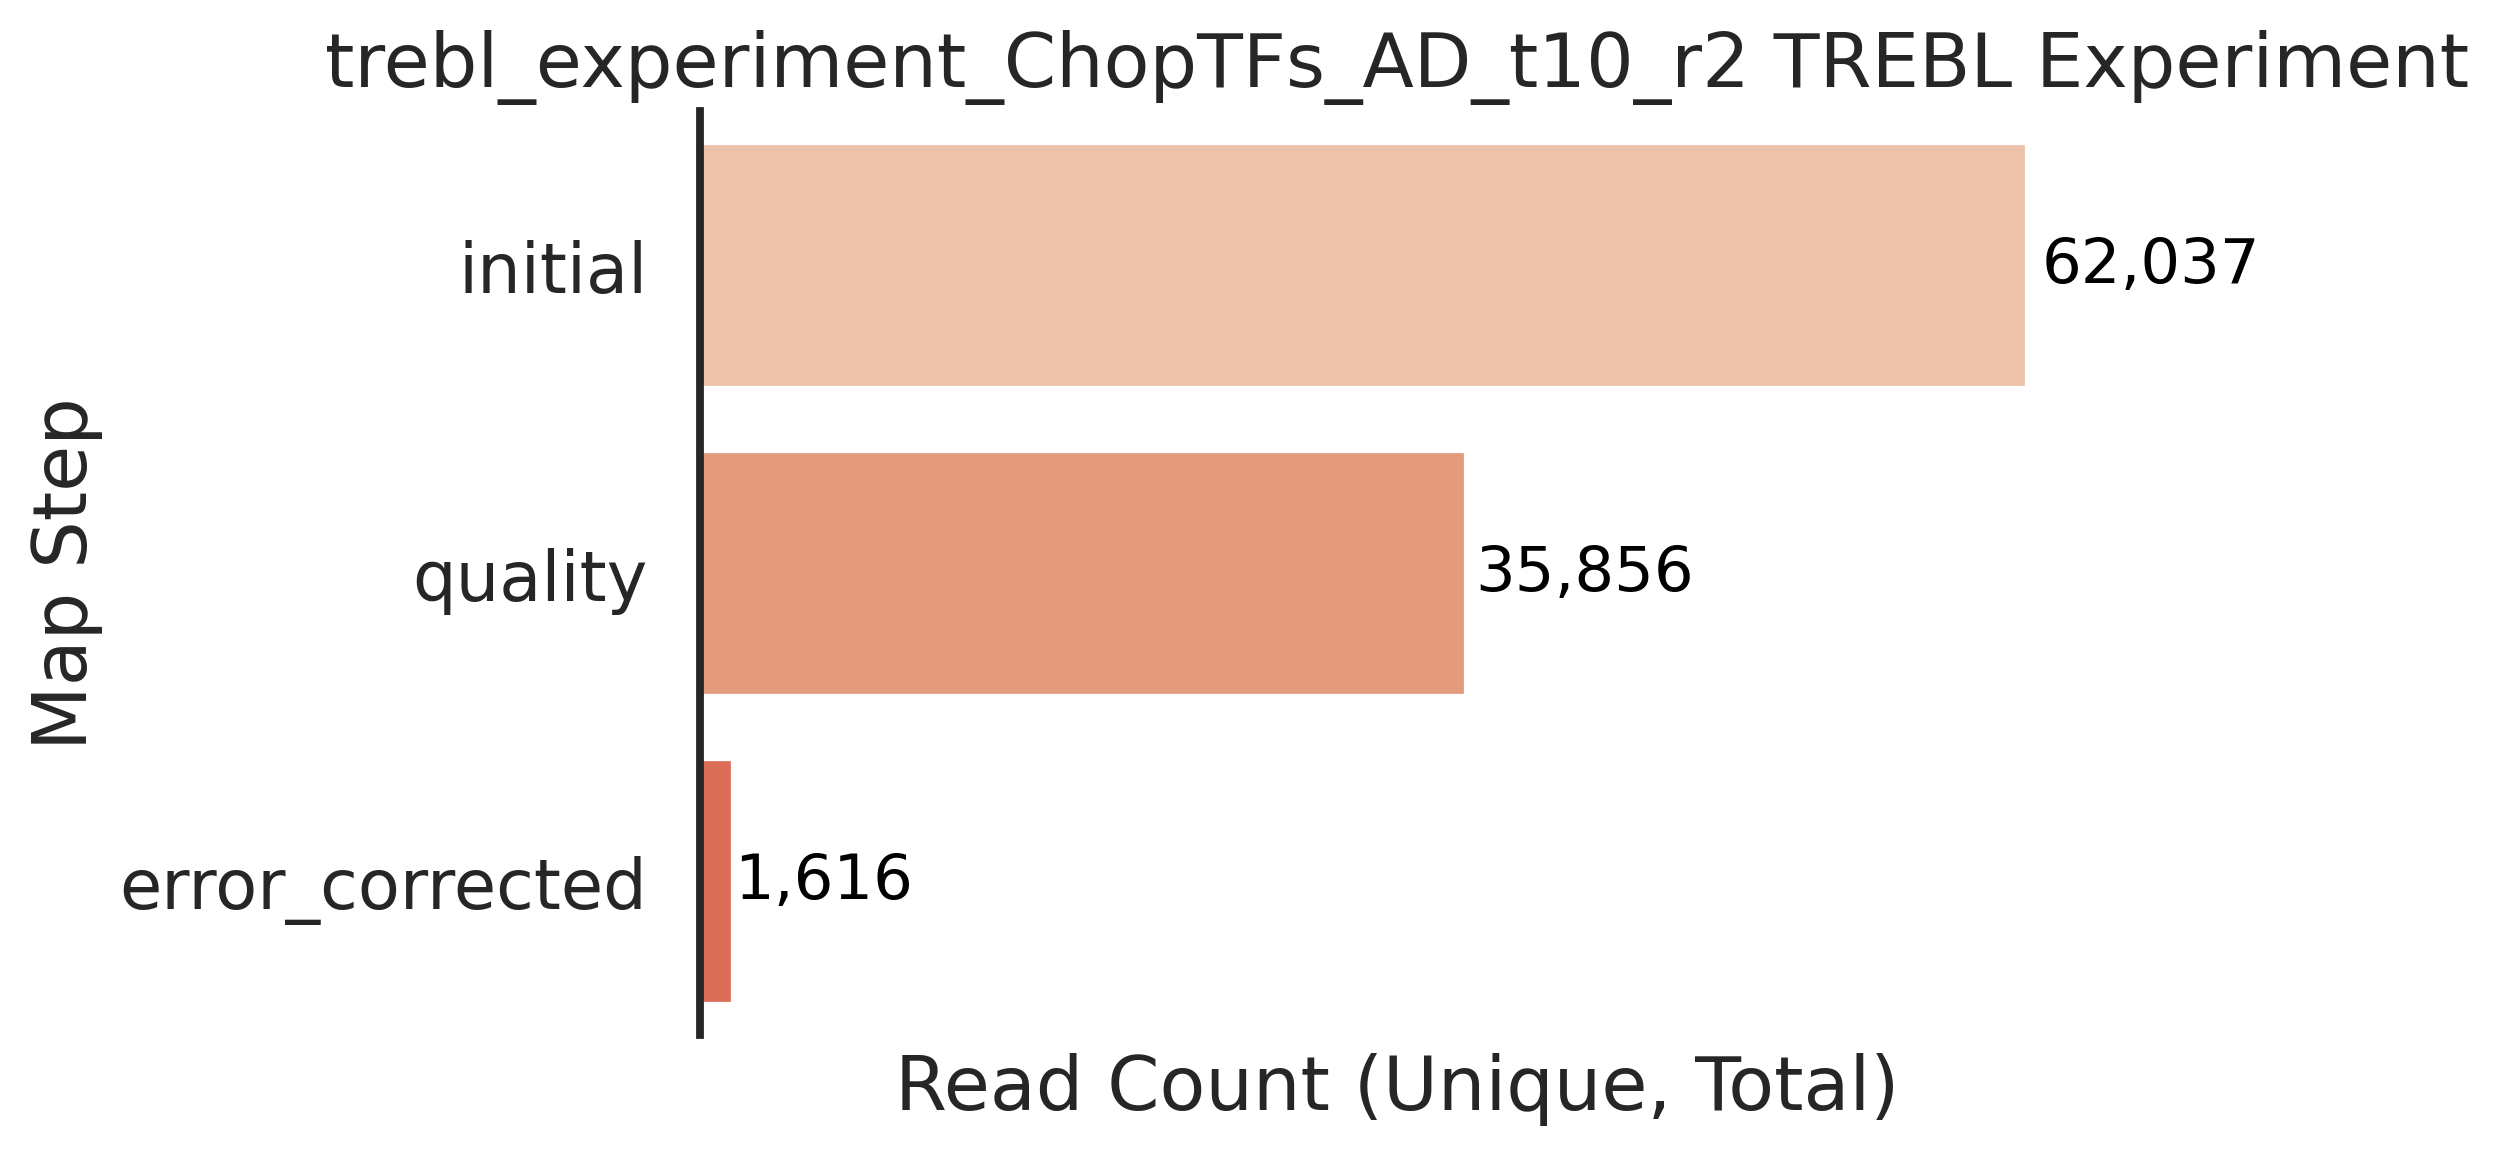

['../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_filtered_barcodes_extracted_whitelist.txt']
Saved barcode whitelist plots: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_whitelist_summary.png


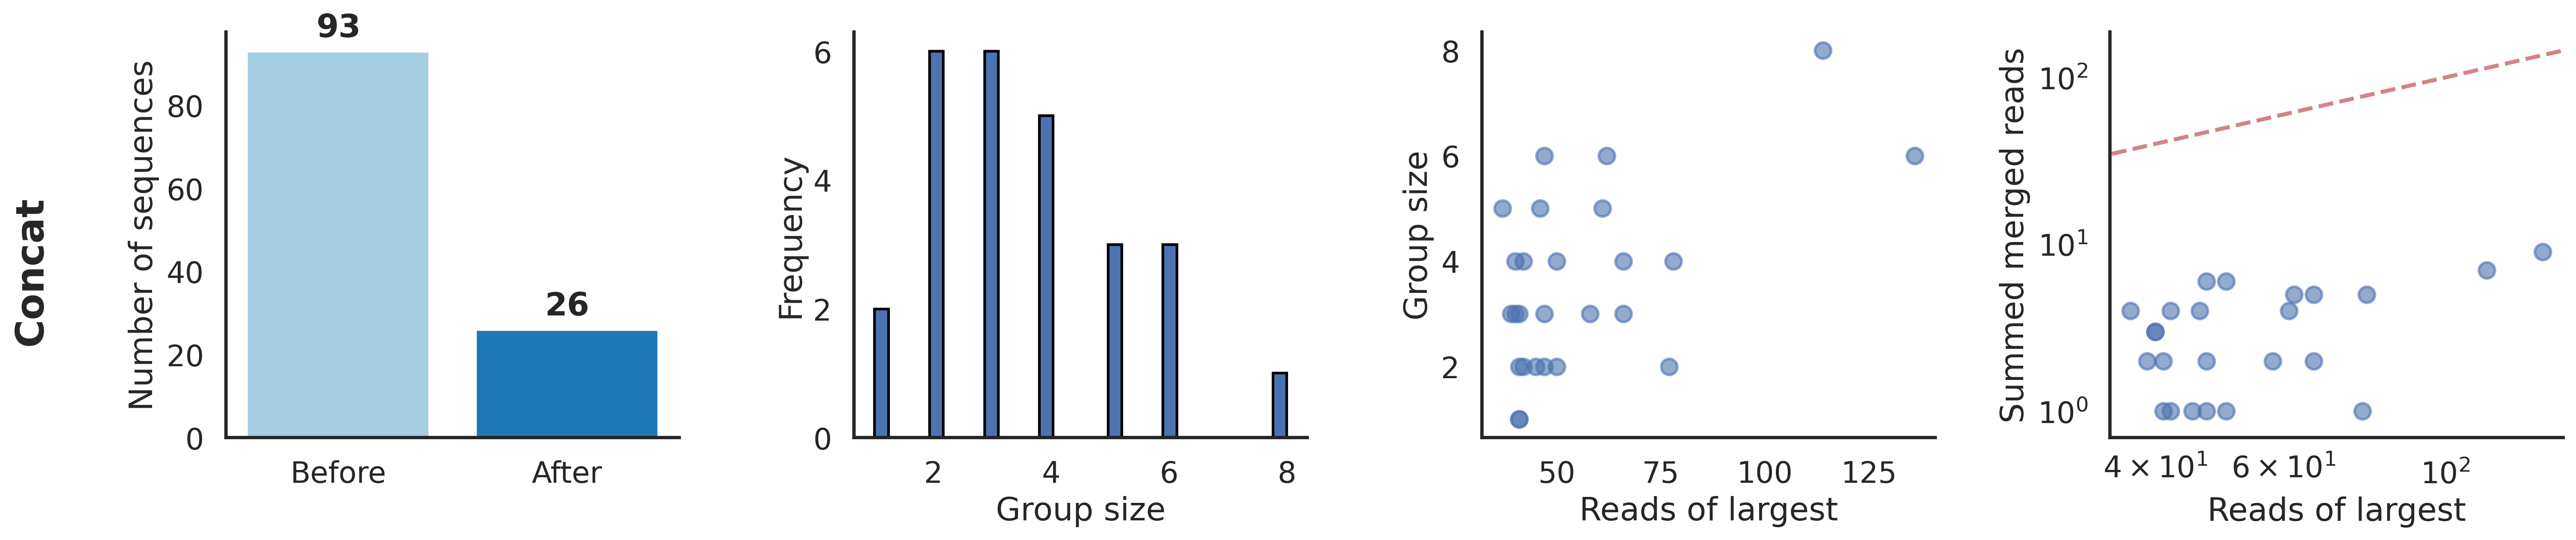

Done in 1.77 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_umi_extracted.fastq (1616 reads)...


Writing FASTQ: 100%|██████████| 1616/1616 [00:00<00:00, 1206263.62it/s]

FASTQ complete: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_umi_extracted.fastq
Done in 0.08 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_unique_barcodes
Writing FASTA to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index


Settings:
  Output files: "../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes.fa
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN

Building a SMALL index
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.3.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.3.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.4.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.4.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.1.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.1.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_barcodes_index.2.

Done in 1.41 seconds.

Aligning .FASTQ to reference .FA ...


1605 reads; of these:
  1605 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    1605 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...
Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /tmp/trebl_pipeline_e9r9vke9/trebl_experiment_ChopTFs_AD_t10_r2_umi_extracted.sorted.bam -S ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_umi_deduplicated.bam --method=directional --per-contig --per-gene
# job started at Wed Feb 18 19:07:05 2026 on n0027.savio2 -- 03a18915-22b4-4cb0-90fa-bf48cb1c866c
# pid: 2298075, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filt

/global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)


Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 48
Done in 0.01 seconds.

Whitelist application complete for trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2 at trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD

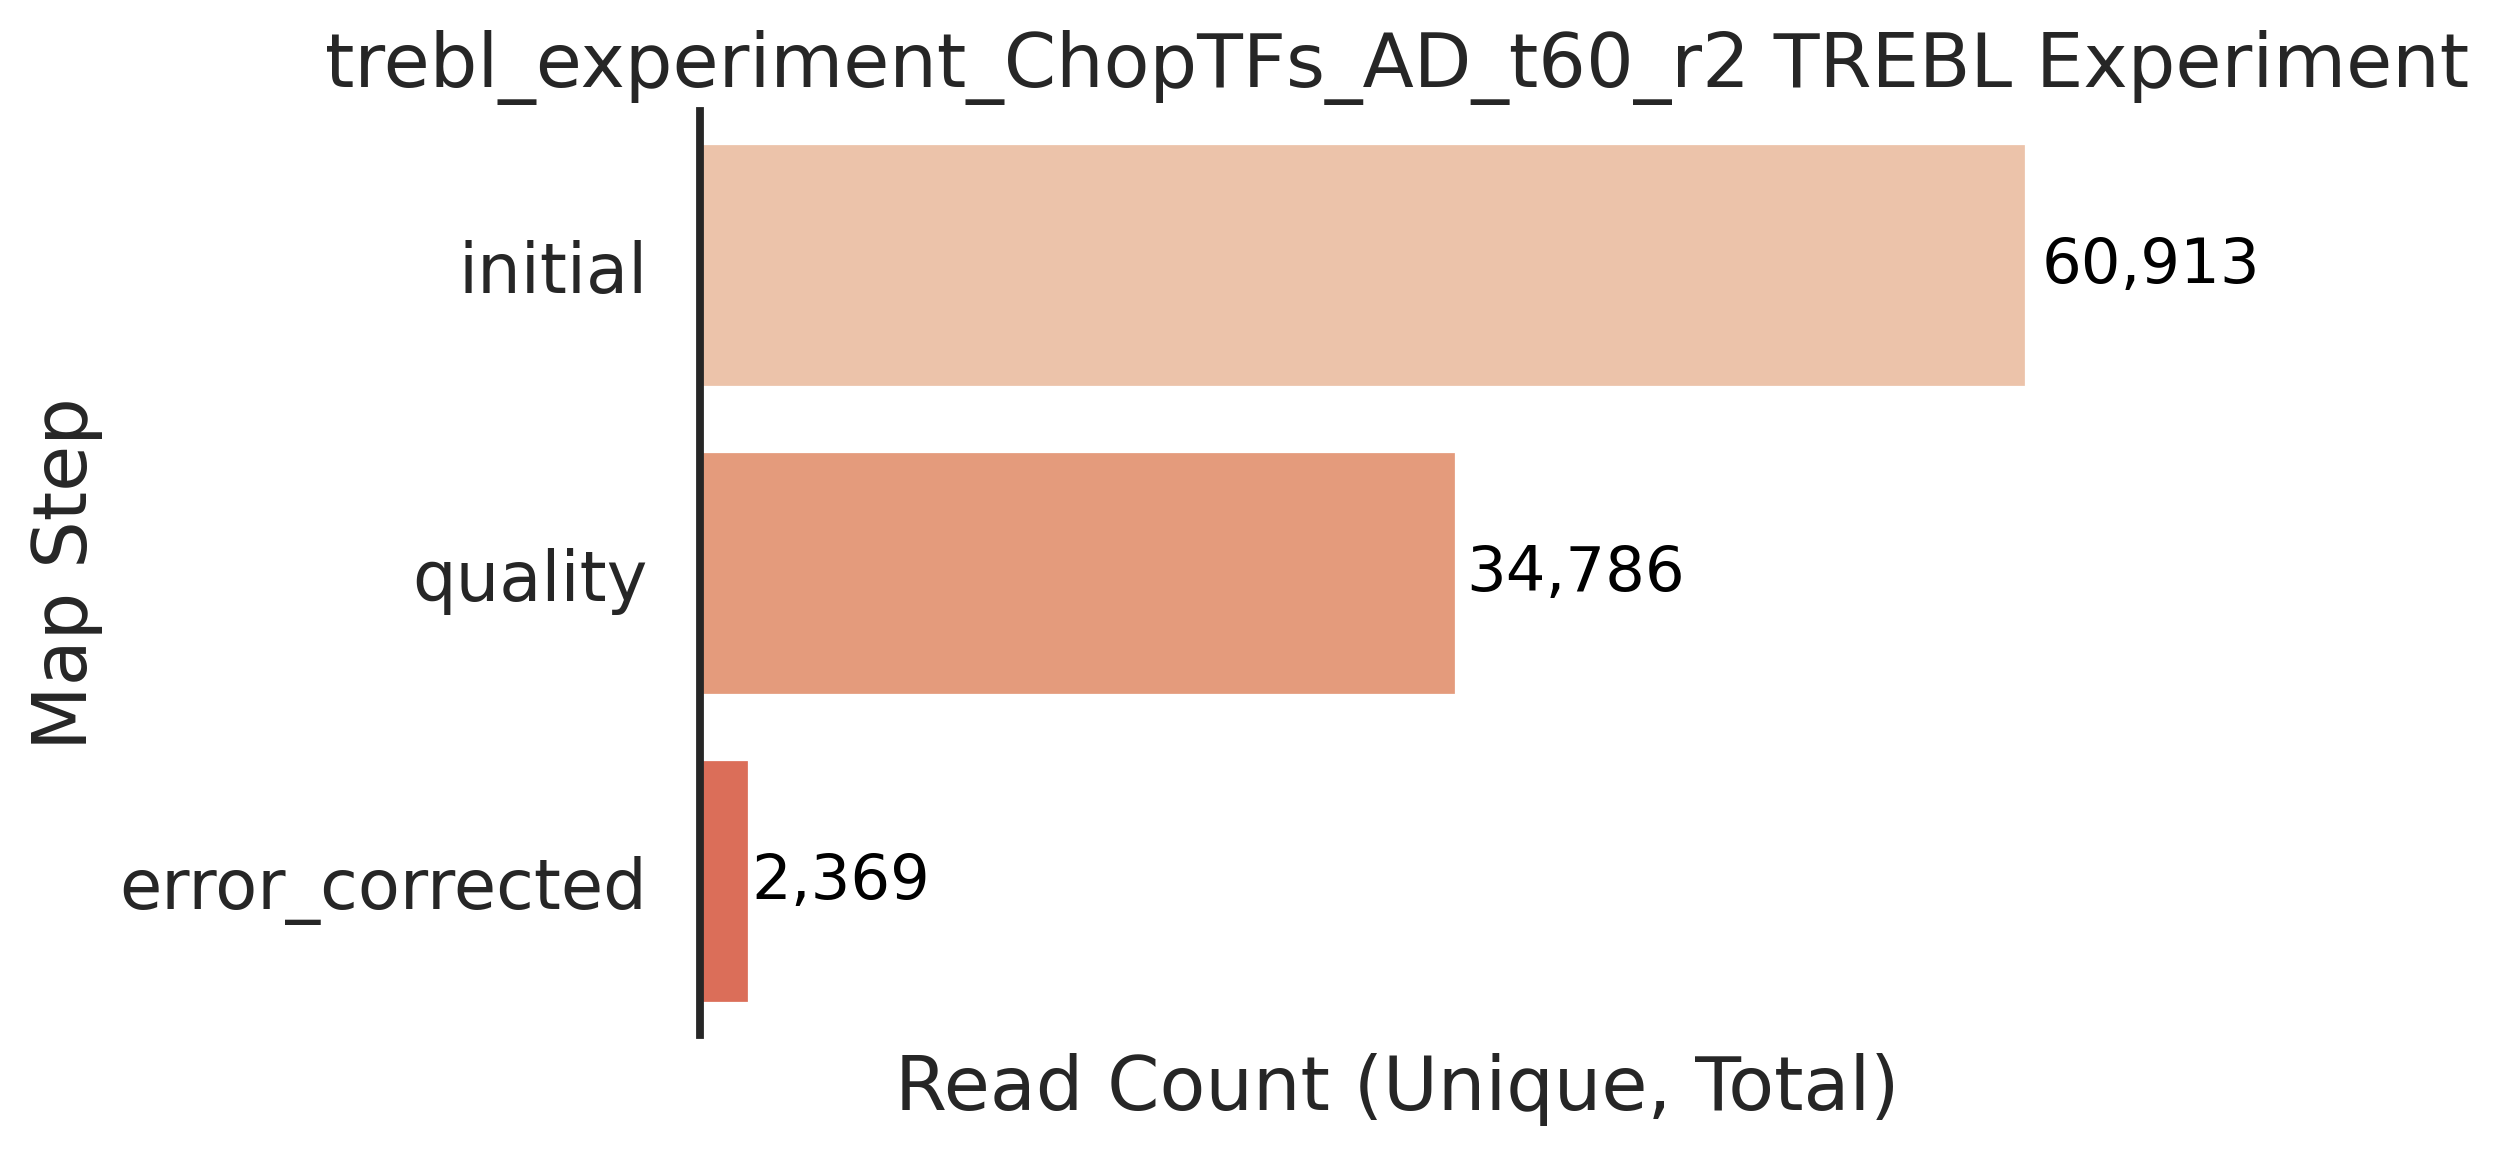

['../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_filtered_barcodes_extracted_whitelist.txt']
Saved barcode whitelist plots: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_whitelist_summary.png


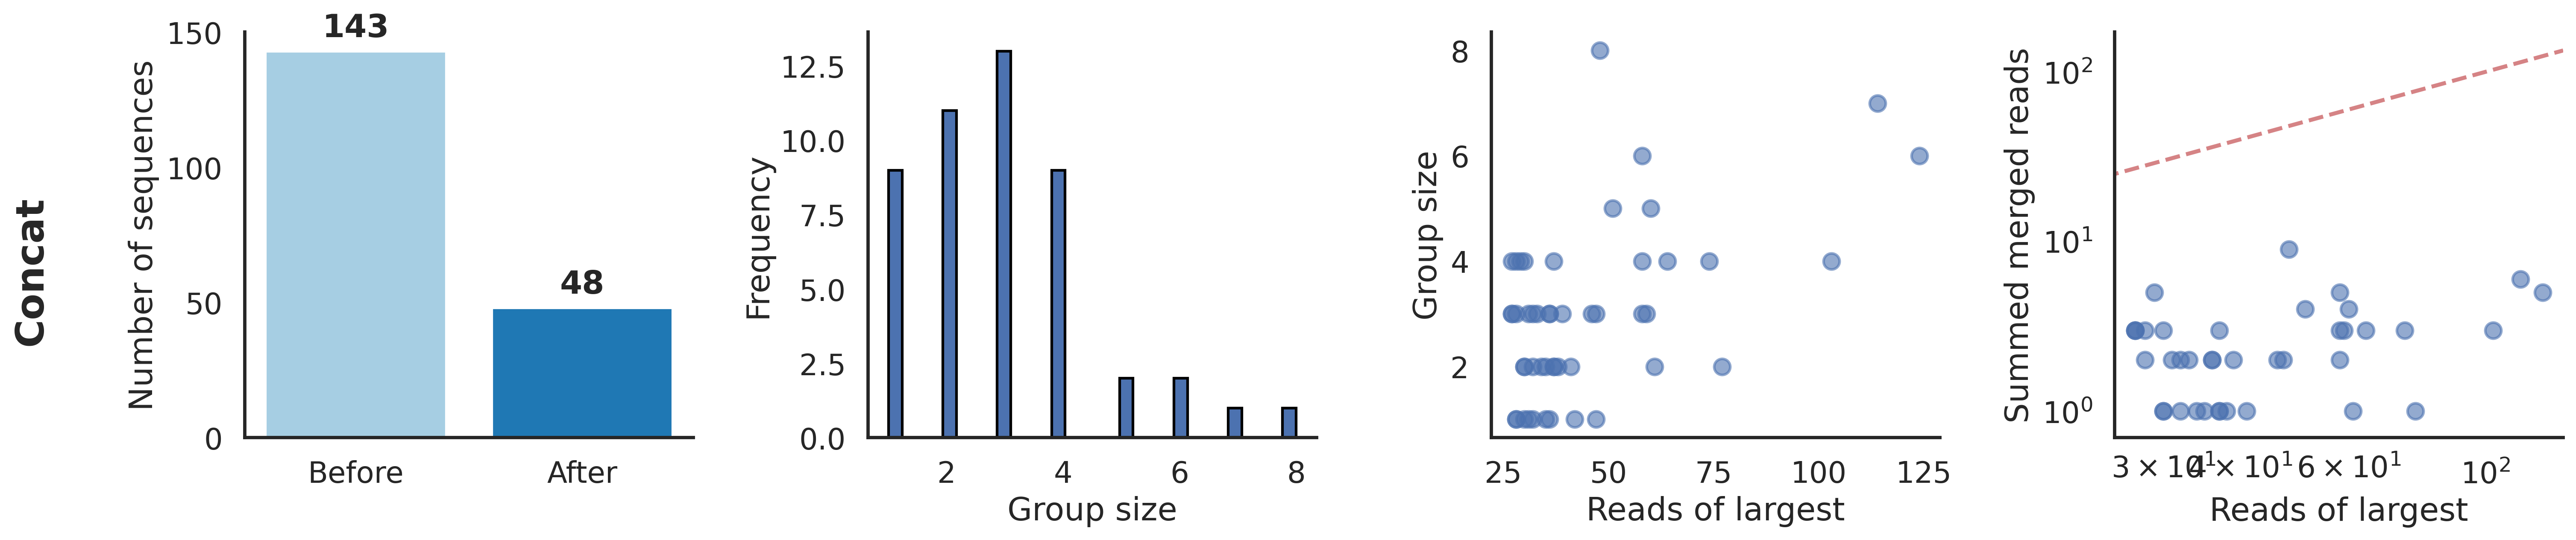

Done in 1.63 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_umi_extracted.fastq (2369 reads)...


Writing FASTQ: 100%|██████████| 2369/2369 [00:00<00:00, 1026265.87it/s]

FASTQ complete: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_umi_extracted.fastq
Done in 0.01 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_unique_barcodes
Writing FASTA to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index


Settings:
  Output files: "../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes.fa
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN

Building a SMALL index
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.3.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.3.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.4.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.4.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.1.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.1.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_barcodes_index.2.

Done in 1.16 seconds.

Aligning .FASTQ to reference .FA ...


2339 reads; of these:
  2339 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    2339 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /tmp/trebl_pipeline_rvcd5701/trebl_experiment_ChopTFs_AD_t60_r2_umi_extracted.sorted.bam -S ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_umi_deduplicated.bam --method=directional --per-contig --per-gene
# job started at Wed Feb 18 19:07:35 2026 on n0027.savio2 -- 51e7dc82-9cc3-42d2-af6f-b8a543c1133c
# pid: 2347732, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None

/global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)


Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 80
Done in 0.01 seconds.

Whitelist application complete for trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2 at trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_error

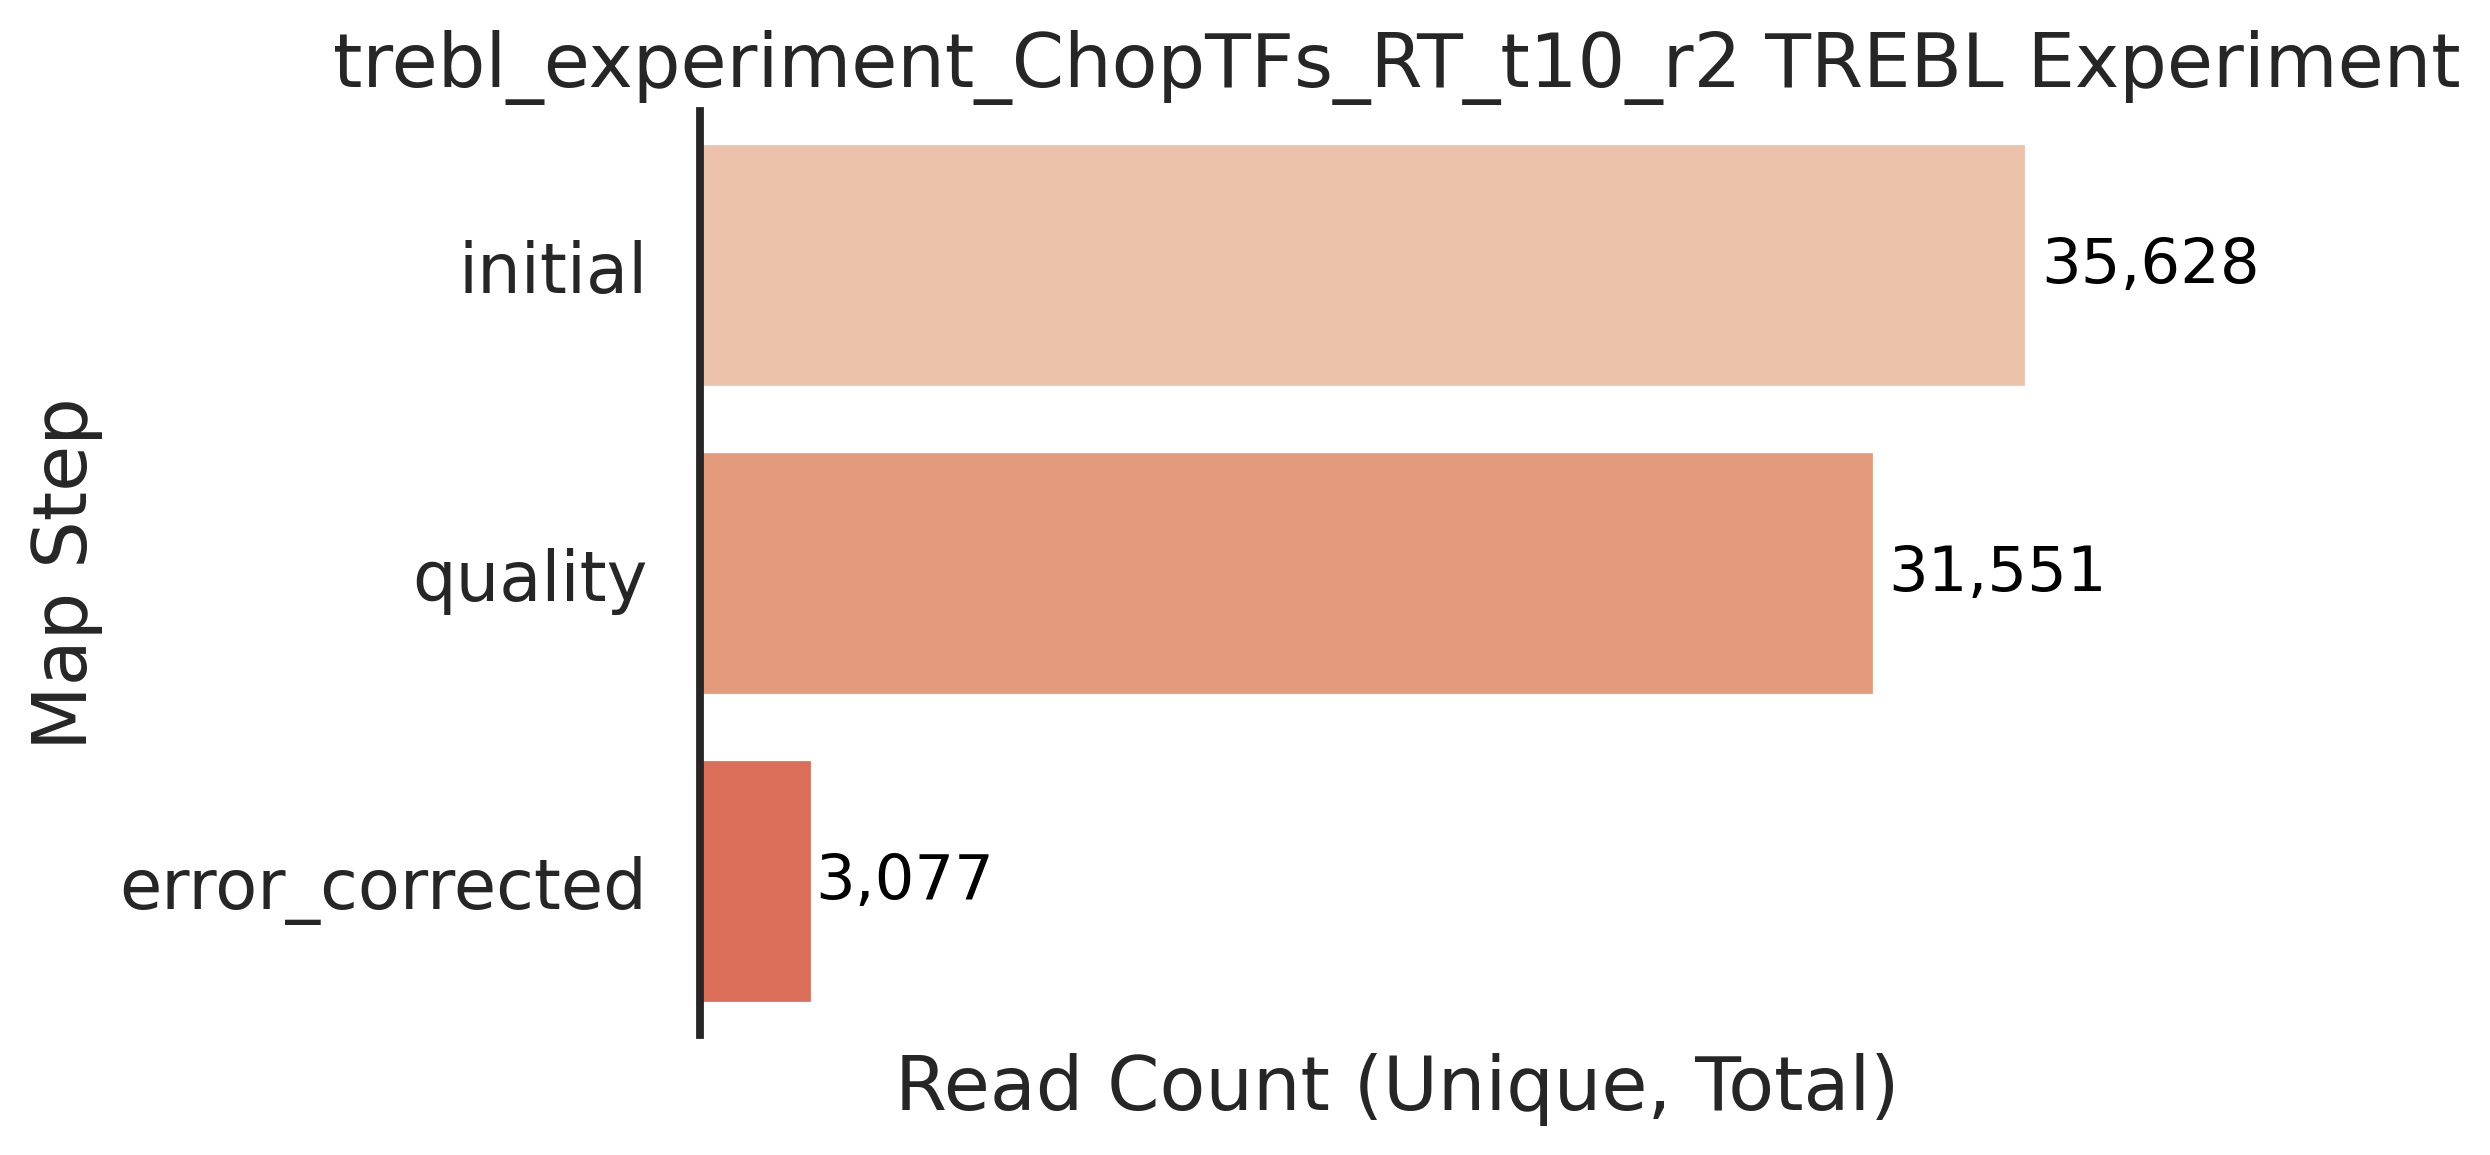

['../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_filtered_barcodes_extracted_whitelist.txt']
Saved barcode whitelist plots: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_whitelist_summary.png


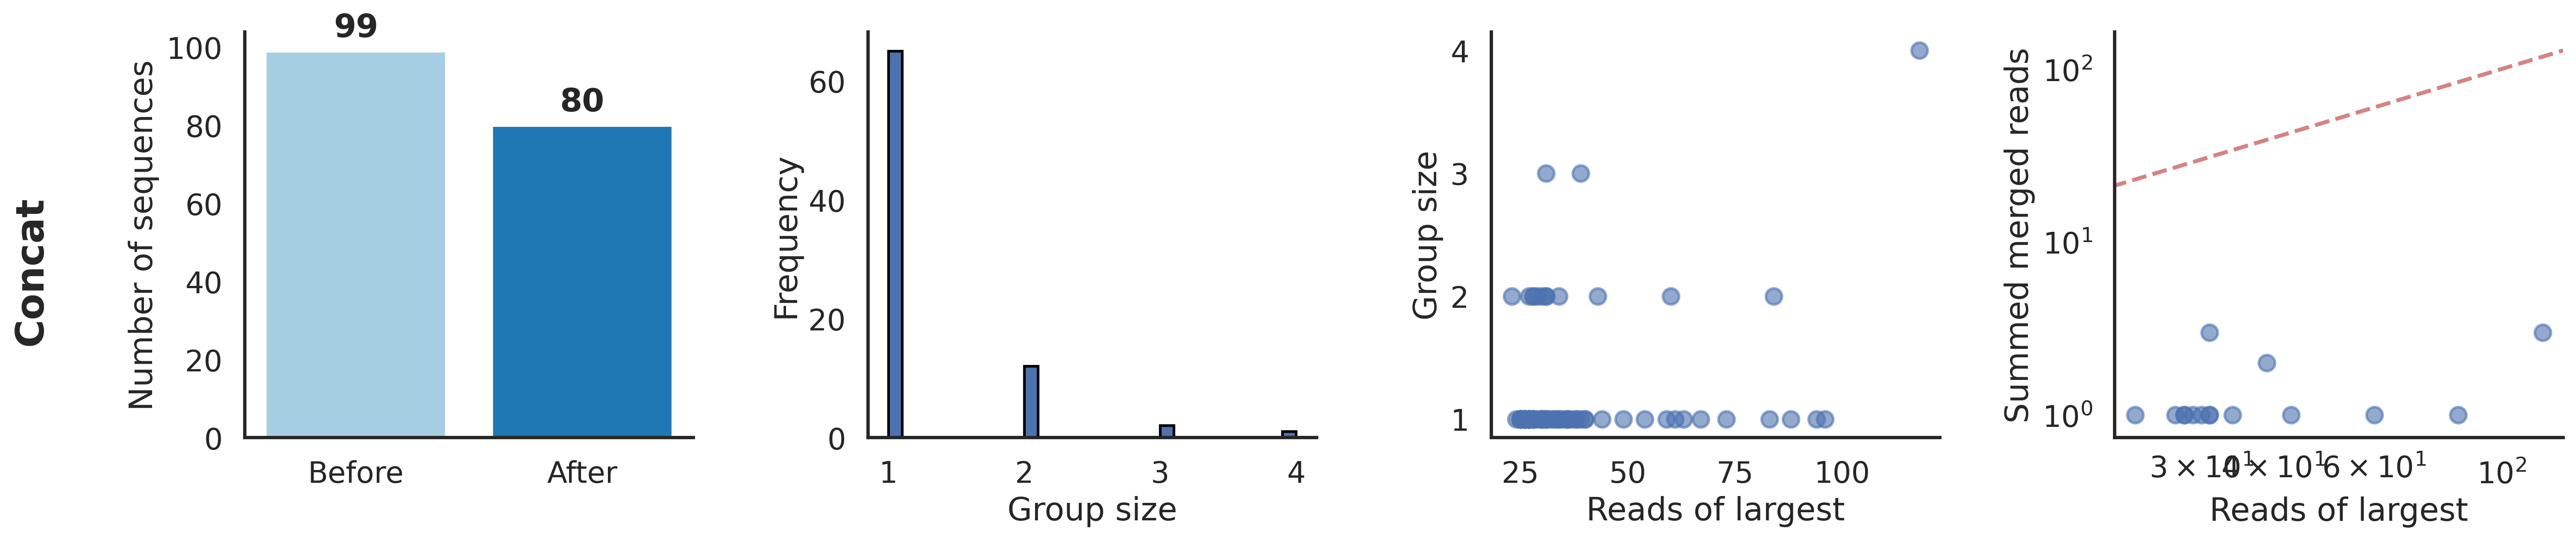

Done in 1.60 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_umi_extracted.fastq (3077 reads)...


Writing FASTQ: 100%|██████████| 3077/3077 [00:00<00:00, 1411866.69it/s]

FASTQ complete: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_umi_extracted.fastq
Done in 0.01 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_unique_barcodes
Writing FASTA to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index


Settings:
  Output files: "../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes.fa
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN

Building a SMALL index
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.3.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.3.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.4.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.4.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.1.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.1.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_barcodes_index.2.

Done in 1.18 seconds.

Aligning .FASTQ to reference .FA ...


3050 reads; of these:
  3050 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    3050 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /tmp/trebl_pipeline_xi_22qd9/trebl_experiment_ChopTFs_RT_t10_r2_umi_extracted.sorted.bam -S ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_umi_deduplicated.bam --method=directional --per-contig --per-gene
# job started at Wed Feb 18 19:08:03 2026 on n0027.savio2 -- f258f802-f5bf-4f79-972f-28ed37bb621d
# pid: 2393578, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None

/global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)


Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/examples/output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 104
Done in 0.01 seconds.

Whitelist application complete for trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2 at trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_erro

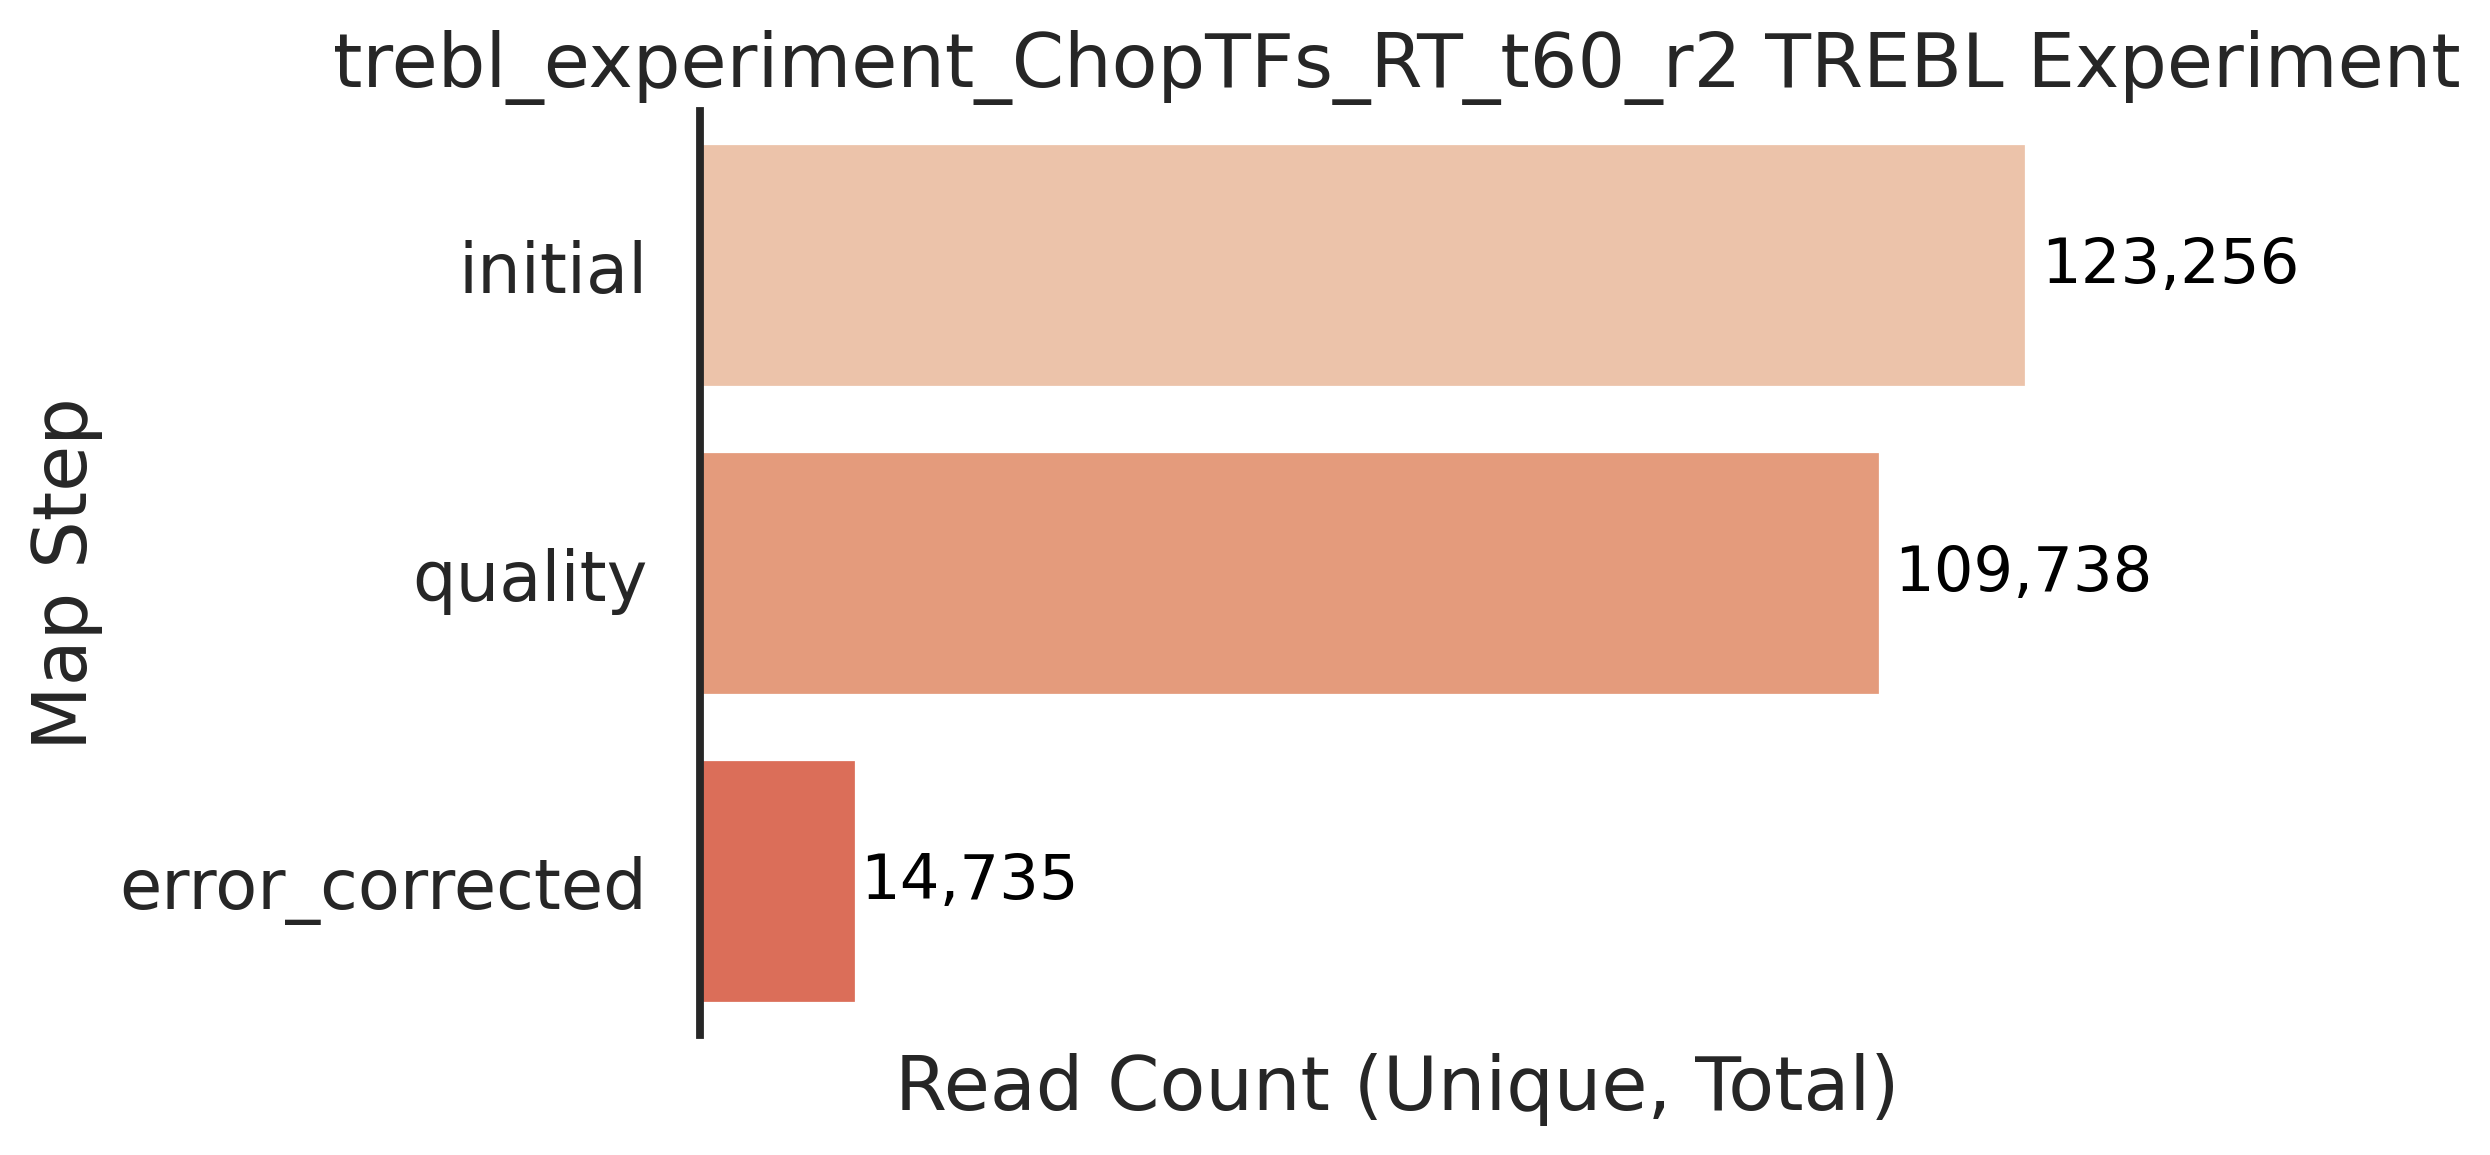

['../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_filtered_barcodes_extracted_whitelist.txt']
Saved barcode whitelist plots: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_whitelist_summary.png


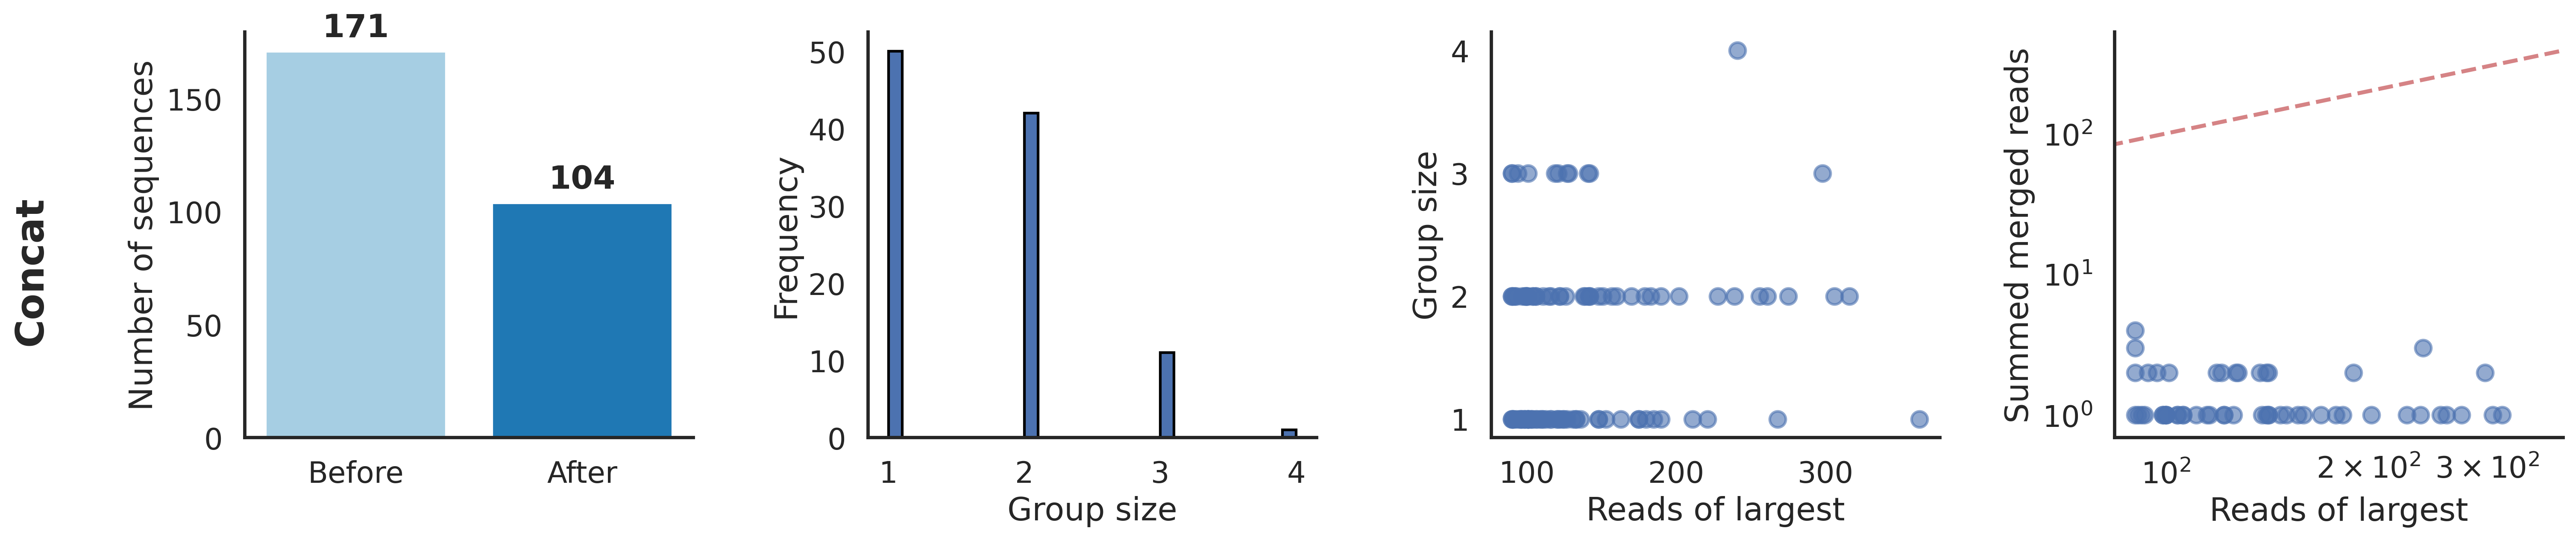

Done in 1.73 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_umi_extracted.fastq (14735 reads)...


Writing FASTQ: 100%|██████████| 14735/14735 [00:00<00:00, 1372669.45it/s]

FASTQ complete: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_umi_extracted.fastq
Done in 0.03 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_unique_barcodes
Writing FASTA to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index


Settings:
  Output files: "../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes.fa
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN

Building a SMALL index
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.3.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.3.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.4.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.4.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.1.bt2.tmp to ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.1.bt2
Renaming ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_barcodes_index.2.

Done in 1.17 seconds.

Aligning .FASTQ to reference .FA ...


14553 reads; of these:
  14553 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    14553 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /tmp/trebl_pipeline_m8n8dru8/trebl_experiment_ChopTFs_RT_t60_r2_umi_extracted.sorted.bam -S ../output/full_analysis/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_umi_deduplicated.bam --method=directional --per-contig --per-gene
# job started at Wed Feb 18 19:08:39 2026 on n0027.savio2 -- d030914f-5142-4962-aac8-c9ccea90f2cc
# pid: 2450062, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None

Plotting BCs: 100%|██████████| 2/2 [00:00<00:00, 20.89it/s]


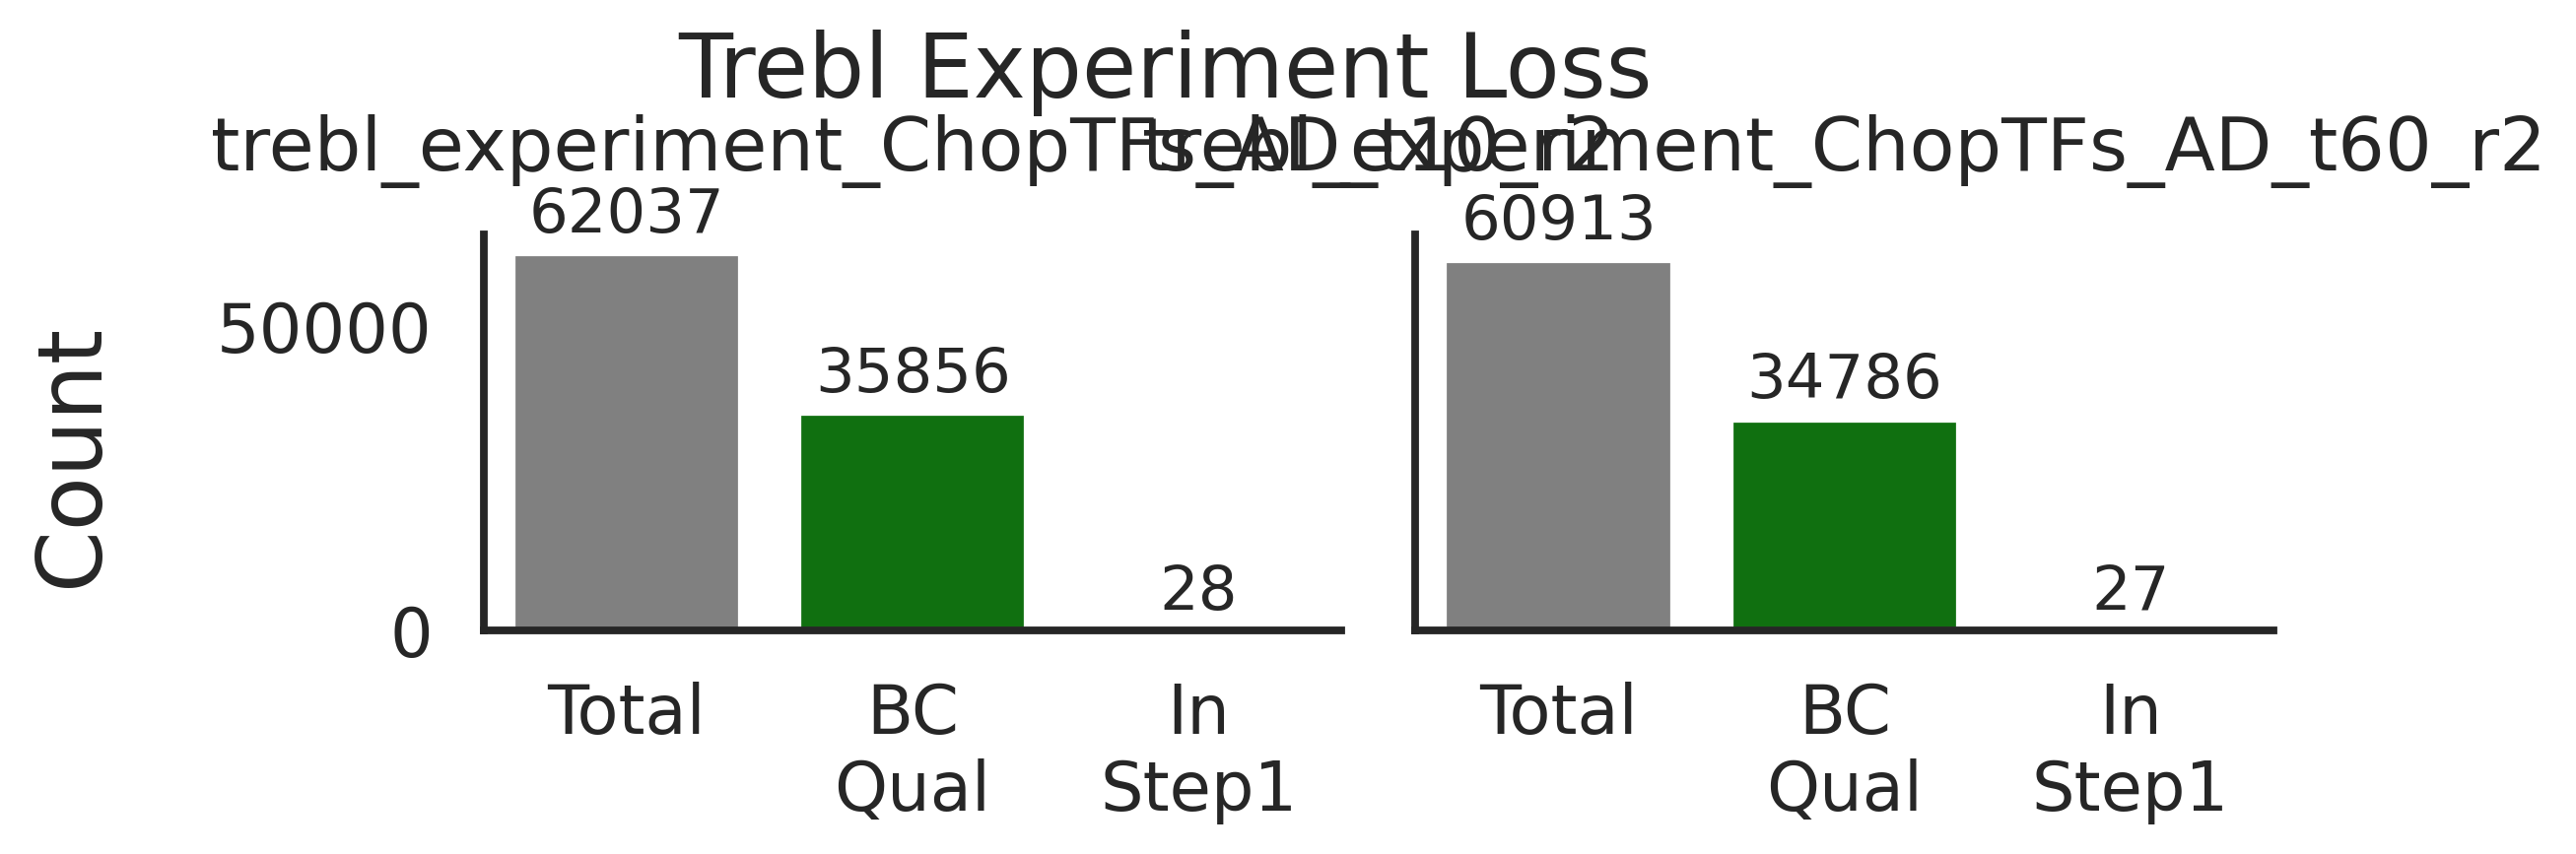

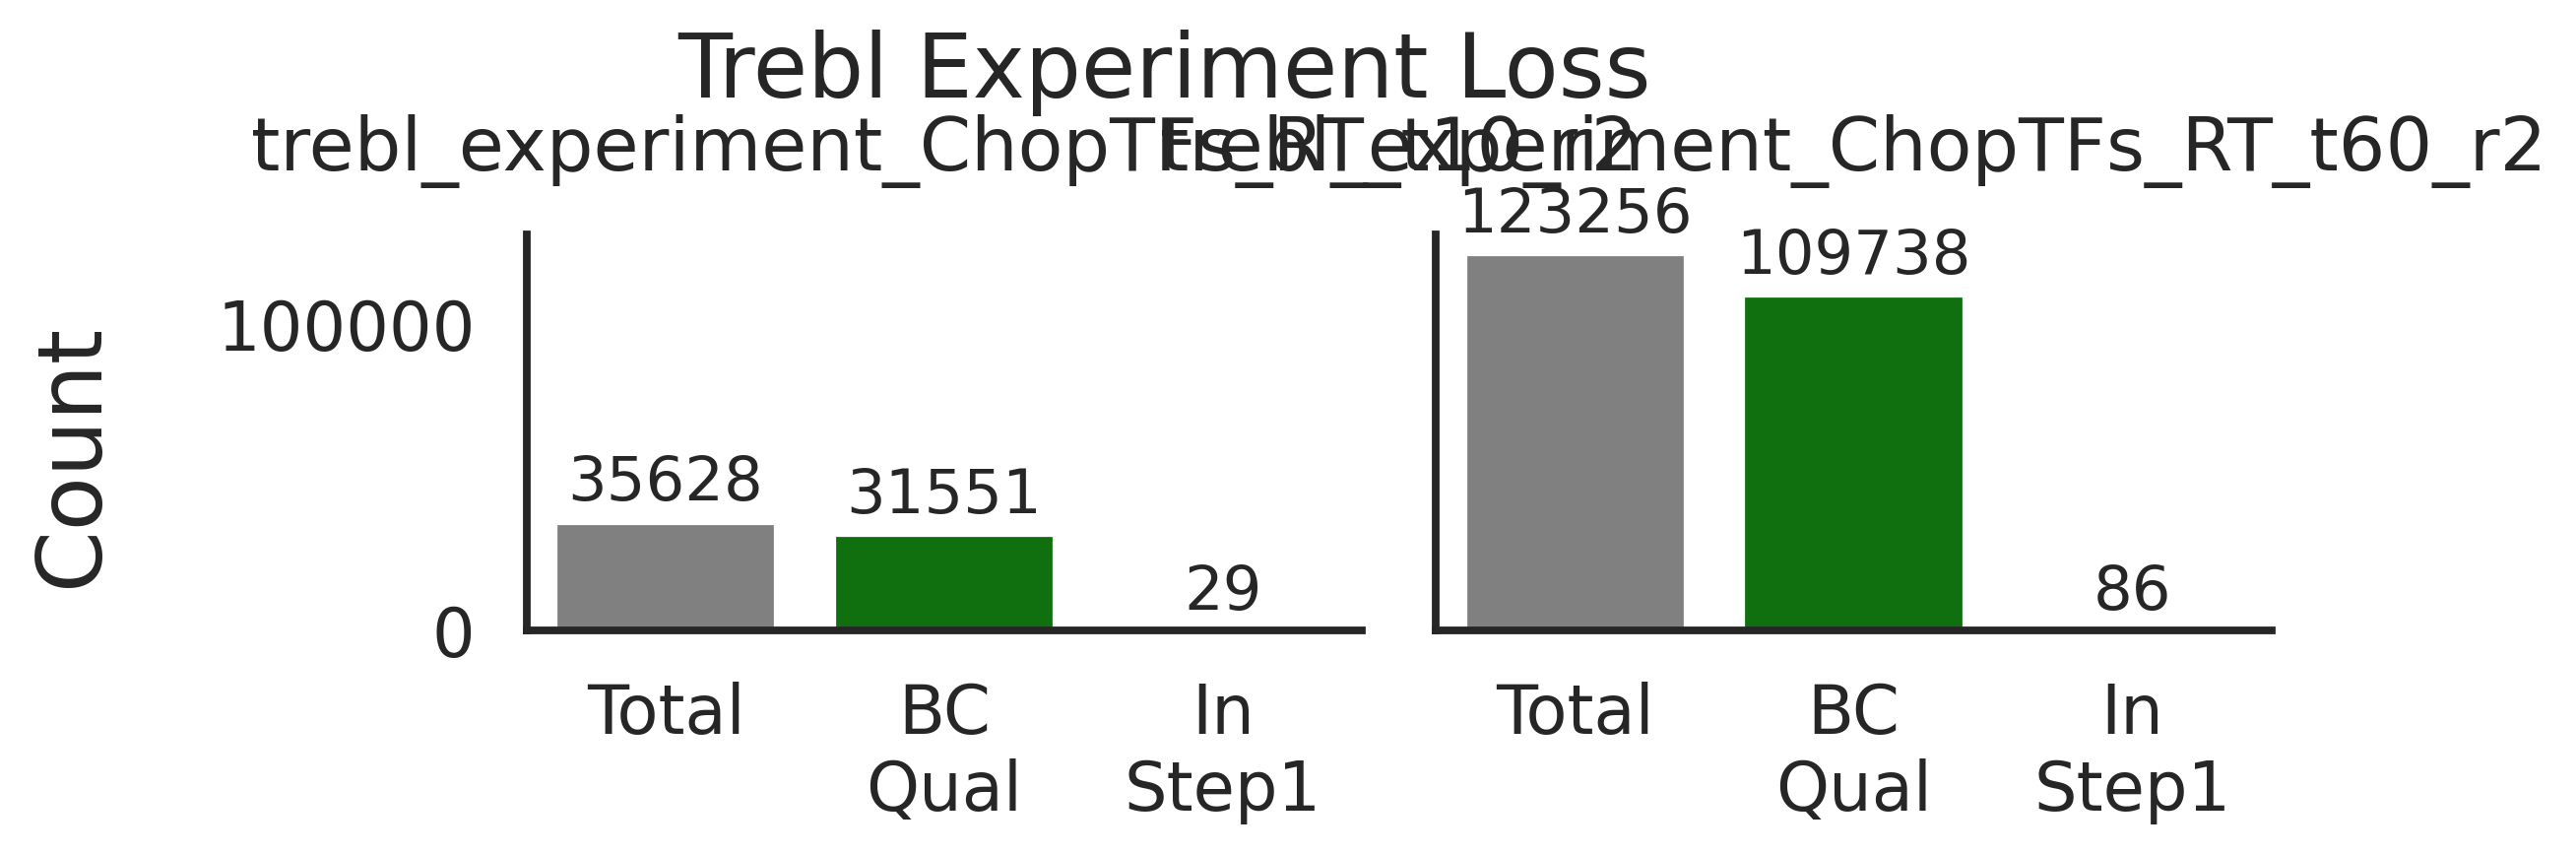

In [15]:
# Run TREBL experiment with BOTH simple and directional/complex UMI deduplication
trebl_results = pipeline.trebl_experiment_analysis(
    AD_seq_files=trebl_AD_seq_files,
    AD_bc_objects=AD_bc_objects,
    RT_seq_files=trebl_RT_seq_files,
    RT_bc_objects=RT_bc_objects,
    reverse_complement=True,
    step1_map_csv_path="../output/full_analysis/step1.csv",  # Update with your step1 CSV path
    AD_umi_object=AD_UMI,
    RT_umi_object=RT_UMI,
    umi_deduplication="both",  # Use BOTH simple and directional/complex deduplication
)

# Access results
# Results contain merged counts from both deduplication methods
AD_results = trebl_results["AD_results"]
RT_results = trebl_results["RT_results"]

## Understanding the Results

When `umi_deduplication='both'` is used:
- Results include columns for both simple UMI counts and directional/complex UMI counts
- The directional method typically gives lower counts as it removes UMIs that likely resulted from PCR/sequencing errors
- For most analyses, the directional/complex counts are recommended for final results

In [38]:
# Calculate activity scores
activity_scores = pipeline.calculate_activity_scores(
    step1_path="../output/full_analysis/step1.csv",
    AD_bc_objects=AD_bc_objects,
    RT_bc_objects=RT_bc_objects,
    time_regex=r"_t(\d+)",
    rep_regex=r"_r(\d+)",
)

# Display the results
activity_scores

AD,rep


## Next Steps

After completing this full analysis:

1. **Review outputs** in the `output/full_analysis` directory
2. **Check loss tables** - You should see an additional 'error_corrected' step
3. **Compare UMI deduplication methods** in the output CSVs
4. **Calculate activity scores** using the results (see documentation)

### Key Differences from Quick Start:

- **Error correction** salvages more reads by correcting sequences similar to high-confidence barcodes
- **Directional UMI deduplication** provides more accurate counts by handling UMI errors
- **Processing time** is significantly longer but provides higher quality results

### Cleanup

After analysis is complete, you can delete the DuckDB database:

In [ ]:
# import os
# os.remove("../db/full_analysis.db")